# UBER Traffic Analysis

## Component - 1

#### Develop a predictive model to accurately forecast hourly traffic volumes at different road junctions based on historical traffic data

## Component - 2

### Data Cleaning & Pre-processing

1. Load Raw Data:
- Read the collected data into pandas DataFrames.

2. Clean Data:
- Handle missing values using methods like imputation or removal (df.fillna(), df.dropna()).
- Remove duplicates (df.drop_duplicates()).
- Correct data types (df.astype()).

3. Aggregate traffic data:
- Compile traffic data into hourly intervals for each junction.
- Ensure data includes relevant details such as vehicle counts.

4. Preprocess the data:
- Normalize or standardize the data to facilitate comparison across different time periods and junctions.

### Feature Engineering and Selection

1. Create new features from raw data:
- Generate time-based features such as hour of the day, day of the week, and month.
- Develop lag features by including traffic data from previous hours or days to capture temporal dependencies.
- Create binary indicators for weekends and special events to account for their impact on traffic.

2. Evaluate feature importance:
- Use statistical methods and machine learning techniques (e.g., correlation analysis, feature importance from tree-based models) to assess the relevance of each feature.
- Select the most influential features for model training to improve efficiency and performance.

### Implementation

In [1]:

import os
import warnings

# Silence warnings and TensorFlow info
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

# Importing Libraries:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import requests

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


# ======= stepwise_model_pipeline.py =======
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# For ARIMA
import statsmodels.api as sm
from itertools import product

In [2]:
df = pd.read_csv('Dataset_Uber Traffic.csv')

In [3]:
df.head()

,DateTime,Junction,Vehicles,ID
0,01/11/15 0:00,1,15,20151101001
1,01/11/15 1:00,1,13,20151101011
2,01/11/15 2:00,1,10,20151101021
3,01/11/15 3:00,1,7,20151101031
4,01/11/15 4:00,1,9,20151101041


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [5]:
df.shape

(48120, 4)

In [6]:
df.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


In [7]:
df.isna().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.shape

(48120, 4)

In [10]:
df['DateTime'] = pd.to_datetime(df['DateTime'],errors= 'coerce')

In [11]:
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-01-11 00:00:00,1,15,20151101001
1,2015-01-11 01:00:00,1,13,20151101011
2,2015-01-11 02:00:00,1,10,20151101021
3,2015-01-11 03:00:00,1,7,20151101031
4,2015-01-11 04:00:00,1,9,20151101041


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB


In [13]:
df = df.set_index('DateTime')

In [14]:
hourly_data = df.groupby('Junction').resample('H')['Vehicles'].sum().reset_index()
hourly_data.head()

,Junction,DateTime,Vehicles
0,1,2015-01-11 00:00:00,15
1,1,2015-01-11 01:00:00,13
2,1,2015-01-11 02:00:00,10
3,1,2015-01-11 03:00:00,7
4,1,2015-01-11 04:00:00,9


In [15]:
hourly_data_scaled = hourly_data.copy()

standard_scaler = StandardScaler()
hourly_data_scaled['Vehicles'] = standard_scaler.fit_transform(hourly_data_scaled[['Vehicles']])

In [16]:
hourly_data_scaled.head()

,Junction,DateTime,Vehicles
0,1,2015-01-11 00:00:00,0.105143
1,1,2015-01-11 01:00:00,0.001506
2,1,2015-01-11 02:00:00,-0.153950
3,1,2015-01-11 03:00:00,-0.309406
4,1,2015-01-11 04:00:00,-0.205768


In [17]:
hourly_data_scaled['Hour'] = hourly_data_scaled['DateTime'].dt.hour
hourly_data_scaled['DayOfWeek'] = hourly_data_scaled['DateTime'].dt.dayofweek   # 0=Mon, 6=Sun
hourly_data_scaled['Month'] = hourly_data_scaled['DateTime'].dt.month

In [18]:
hourly_data_scaled.head()

,Junction,DateTime,Vehicles,Hour,DayOfWeek,Month
0,1,2015-01-11 00:00:00,0.105143,0,6,1
1,1,2015-01-11 01:00:00,0.001506,1,6,1
2,1,2015-01-11 02:00:00,-0.153950,2,6,1
3,1,2015-01-11 03:00:00,-0.309406,3,6,1
4,1,2015-01-11 04:00:00,-0.205768,4,6,1


In [19]:
for lag in [1,24,168]:   # previous 1hour, 1day, 1week
    hourly_data_scaled[f'Lag{lag}'] = hourly_data_scaled.groupby('Junction')['Vehicles'].shift(lag)

In [20]:
hourly_data_scaled.head()

,Junction,DateTime,Vehicles,Hour,DayOfWeek,Month,Lag1,Lag24,Lag168
0,1,2015-01-11 00:00:00,0.105143,0,6,1,NaN,NaN,NaN
1,1,2015-01-11 01:00:00,0.001506,1,6,1,0.105143,NaN,NaN
2,1,2015-01-11 02:00:00,-0.153950,2,6,1,0.001506,NaN,NaN
3,1,2015-01-11 03:00:00,-0.309406,3,6,1,-0.153950,NaN,NaN
4,1,2015-01-11 04:00:00,-0.205768,4,6,1,-0.309406,NaN,NaN


In [21]:
hourly_data_scaled['Rolling_Mean_3'] = hourly_data_scaled.groupby('Junction')['Vehicles'].shift(1).rolling(3).mean()
hourly_data_scaled['Rolling_Mean_24'] = hourly_data_scaled.groupby('Junction')['Vehicles'].shift(1).rolling(24).mean()

In [22]:
hourly_data_scaled.head()

,Junction,DateTime,Vehicles,Hour,DayOfWeek,Month,Lag1,Lag24,Lag168,Rolling_Mean_3,Rolling_Mean_24
0,1,2015-01-11 00:00:00,0.105143,0,6,1,NaN,NaN,NaN,NaN,NaN
1,1,2015-01-11 01:00:00,0.001506,1,6,1,0.105143,NaN,NaN,NaN,NaN
2,1,2015-01-11 02:00:00,-0.153950,2,6,1,0.001506,NaN,NaN,NaN,NaN
3,1,2015-01-11 03:00:00,-0.309406,3,6,1,-0.153950,NaN,NaN,-0.015767,NaN
4,1,2015-01-11 04:00:00,-0.205768,4,6,1,-0.309406,NaN,NaN,-0.153950,NaN


In [23]:
hourly_data_scaled.shape

(84552, 11)

In [24]:
hourly_data_scaled['Is_Weekend'] = hourly_data_scaled['DayOfWeek'].isin([5, 6]).astype(int)

In [25]:
hourly_data_scaled.head()

,Junction,DateTime,Vehicles,Hour,DayOfWeek,Month,Lag1,Lag24,Lag168,Rolling_Mean_3,Rolling_Mean_24,Is_Weekend
0,1,2015-01-11 00:00:00,0.105143,0,6,1,NaN,NaN,NaN,NaN,NaN,1
1,1,2015-01-11 01:00:00,0.001506,1,6,1,0.105143,NaN,NaN,NaN,NaN,1
2,1,2015-01-11 02:00:00,-0.153950,2,6,1,0.001506,NaN,NaN,NaN,NaN,1
3,1,2015-01-11 03:00:00,-0.309406,3,6,1,-0.153950,NaN,NaN,-0.015767,NaN,1
4,1,2015-01-11 04:00:00,-0.205768,4,6,1,-0.309406,NaN,NaN,-0.153950,NaN,1


In [26]:
start_date, end_date = hourly_data_scaled["DateTime"].min(), hourly_data_scaled["DateTime"].max()
print(start_date)
print(end_date)

2015-01-11 00:00:00
2017-12-06 23:00:00


In [27]:
event_df = pd.read_csv('hyderabad_all_special_events_2015_2017_merged.csv')

In [28]:
event_df.head()

,Event,Date,End Date,Type,Venue,Year,City
0,Hyderabad Literary Festival 2015,2015-01-23,2015-01-25,Cultural,Hyderabad Public School,2015,Hyderabad
1,Deccan Festival 2015,2015-02-21,2015-02-25,Cultural,Public Gardens,2015,Hyderabad
2,Golconda Music Festival 2015,2015-02-14,2015-02-15,Concert,Golconda Fort,2015,Hyderabad
3,IPL 2015 - SRH vs RCB,2015-04-13,2015-04-13,Sports,Rajiv Gandhi Stadium,2015,Hyderabad
4,IPL 2015 - SRH vs CSK,2015-05-02,2015-05-02,Sports,Rajiv Gandhi Stadium,2015,Hyderabad


In [29]:
event_df.shape

(89, 7)

In [30]:
event_df['Date'] = pd.to_datetime(event_df['Date'])
event_df['End Date'] = pd.to_datetime(event_df['End Date'])

In [31]:
# --- Initialize columns ---
hourly_data_scaled['Is_Special_Event'] = 0

# --- Assign event flags and types ---
for _, row in event_df.iterrows():
    mask = (hourly_data_scaled['DateTime'] >= row['Date']) & \
           (hourly_data_scaled['DateTime'] <= row['End Date'])
    
    # Mark as special event
    hourly_data_scaled.loc[mask, 'Is_Special_Event'] = 1

In [32]:
hourly_data_scaled.head()

,Junction,DateTime,Vehicles,Hour,DayOfWeek,Month,Lag1,Lag24,Lag168,Rolling_Mean_3,Rolling_Mean_24,Is_Weekend,Is_Special_Event
0,1,2015-01-11 00:00:00,0.105143,0,6,1,NaN,NaN,NaN,NaN,NaN,1,1
1,1,2015-01-11 01:00:00,0.001506,1,6,1,0.105143,NaN,NaN,NaN,NaN,1,1
2,1,2015-01-11 02:00:00,-0.153950,2,6,1,0.001506,NaN,NaN,NaN,NaN,1,1
3,1,2015-01-11 03:00:00,-0.309406,3,6,1,-0.153950,NaN,NaN,-0.015767,NaN,1,1
4,1,2015-01-11 04:00:00,-0.205768,4,6,1,-0.309406,NaN,NaN,-0.153950,NaN,1,1


In [33]:
hourly_data_scaled.isna().sum()

Junction              0
DateTime              0
Vehicles              0
Hour                  0
DayOfWeek             0
Month                 0
Lag1                  4
Lag24                96
Lag168              672
Rolling_Mean_3       12
Rolling_Mean_24      96
Is_Weekend            0
Is_Special_Event      0
dtype: int64

In [34]:
# Calculate the percentage of missing values for each column
missing_percent = (hourly_data_scaled.isna().sum() / len(hourly_data_scaled)) * 100

# Display neatly
missing_percent = missing_percent.round(2).sort_values(ascending=False)
print(missing_percent)

Lag168              0.79
Lag24               0.11
Rolling_Mean_24     0.11
Rolling_Mean_3      0.01
Junction            0.00
DateTime            0.00
Vehicles            0.00
Hour                0.00
DayOfWeek           0.00
Month               0.00
Lag1                0.00
Is_Weekend          0.00
Is_Special_Event    0.00
dtype: float64


In [35]:
hourly_data_scaled = hourly_data_scaled.dropna().reset_index(drop=True)

In [36]:
hourly_data_scaled.isna().sum()

Junction            0
DateTime            0
Vehicles            0
Hour                0
DayOfWeek           0
Month               0
Lag1                0
Lag24               0
Lag168              0
Rolling_Mean_3      0
Rolling_Mean_24     0
Is_Weekend          0
Is_Special_Event    0
dtype: int64

In [37]:
hourly_data_scaled.duplicated().sum()

0

In [38]:
hourly_data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83880 entries, 0 to 83879
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Junction          83880 non-null  int64         
 1   DateTime          83880 non-null  datetime64[ns]
 2   Vehicles          83880 non-null  float64       
 3   Hour              83880 non-null  int32         
 4   DayOfWeek         83880 non-null  int32         
 5   Month             83880 non-null  int32         
 6   Lag1              83880 non-null  float64       
 7   Lag24             83880 non-null  float64       
 8   Lag168            83880 non-null  float64       
 9   Rolling_Mean_3    83880 non-null  float64       
 10  Rolling_Mean_24   83880 non-null  float64       
 11  Is_Weekend        83880 non-null  int32         
 12  Is_Special_Event  83880 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int32(4), int64(2)
memory usage: 7.0 MB


In [39]:
hourly_data_scaled.shape

(83880, 13)

In [40]:
start_date, end_date = hourly_data_scaled["DateTime"].min(), hourly_data_scaled["DateTime"].max()
print(start_date)
print(end_date)

2015-01-18 00:00:00
2017-12-06 23:00:00


In [41]:
# --- Correlation Analysis ---
correlation_matrix = hourly_data_scaled.corr(numeric_only=True)
target_correlation = correlation_matrix['Vehicles'].sort_values(ascending=False)
print("Correlation with Vehicles:\n", target_correlation, "\n")

Correlation with Vehicles:
 Vehicles            1.000000
Lag1                0.977039
Rolling_Mean_3      0.961804
Rolling_Mean_24     0.895035
Lag24               0.863008
Lag168              0.624622
Hour                0.134953
Is_Special_Event   -0.011704
DayOfWeek          -0.049035
Is_Weekend         -0.056929
Month              -0.073765
Junction           -0.382521
Name: Vehicles, dtype: float64 



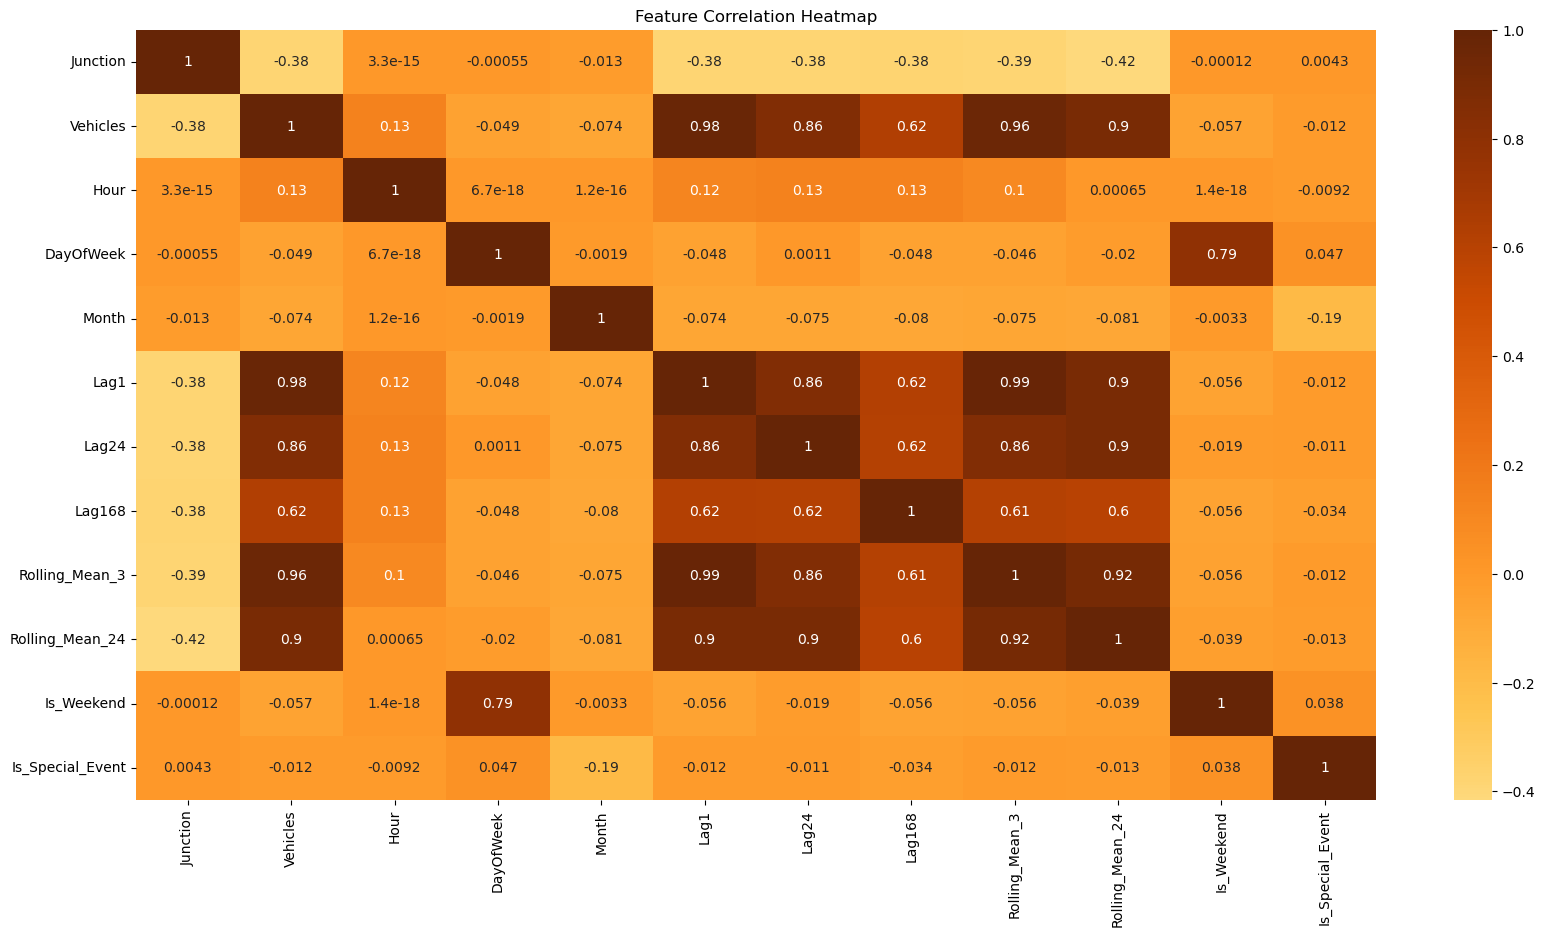

In [42]:
plt.figure(figsize=(20,10))
sns.heatmap(correlation_matrix, annot=True,cmap="YlOrBr", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [43]:
hourly_data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83880 entries, 0 to 83879
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Junction          83880 non-null  int64         
 1   DateTime          83880 non-null  datetime64[ns]
 2   Vehicles          83880 non-null  float64       
 3   Hour              83880 non-null  int32         
 4   DayOfWeek         83880 non-null  int32         
 5   Month             83880 non-null  int32         
 6   Lag1              83880 non-null  float64       
 7   Lag24             83880 non-null  float64       
 8   Lag168            83880 non-null  float64       
 9   Rolling_Mean_3    83880 non-null  float64       
 10  Rolling_Mean_24   83880 non-null  float64       
 11  Is_Weekend        83880 non-null  int32         
 12  Is_Special_Event  83880 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int32(4), int64(2)
memory usage: 7.0 MB


In [44]:
all_features = ['Hour', 'DayOfWeek', 'Month', 'Lag1', 'Lag24', 'Lag168', 'Is_Weekend', 'Is_Special_Event', 'Rolling_Mean_3', 'Rolling_Mean_24']

X = hourly_data_scaled.drop(['Junction', 'DateTime', 'Vehicles'], axis = 1)
y = hourly_data_scaled['Vehicles']

In [45]:
Random_Forest = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)
Random_Forest.fit(X,y)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [46]:
feature_importances = Random_Forest.feature_importances_
feature_df = pd.DataFrame({
    "Features": all_features,
    "Importances": feature_importances
}).sort_values(by="Importances", ascending=False)

In [47]:
feature_df

,Features,Importances
3,Lag1,0.956275
0,Hour,0.012841
7,Is_Special_Event,0.007870
6,Is_Weekend,0.007372
4,Lag24,0.004986
5,Lag168,0.004813
2,Month,0.002834
1,DayOfWeek,0.002103
9,Rolling_Mean_24,0.000559
8,Rolling_Mean_3,0.000347


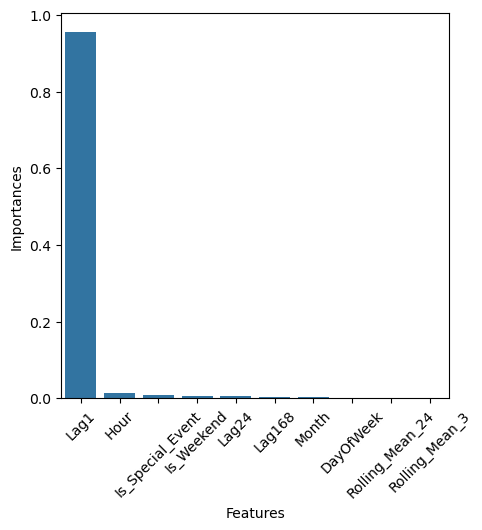

In [48]:
plt.figure(figsize=(5, 5))
sns.barplot(data = feature_df, x="Features", y="Importances")
plt.xticks(rotation = 45)
plt.show()

In [49]:
most_influential_features = feature_df['Features'].head(5).tolist()
most_influential_features

['Lag1', 'Hour', 'Is_Special_Event', 'Is_Weekend', 'Lag24']

## Component - 3

### Data Collection and Integration

1. Identify and access relevant data sources:
- Traffic data: This data is provided to you in the dataset.
- Weather data: Collect historical weather data from meteorological services, including temperature, precipitation, humidity, and wind speed.
- Note: For instance, check the below:
    - Temperature: It can affect vehicle performance and road conditions.
    - Precipitation (rain, snow): Directly impacts road safety and driver behavior.
    - Humidity: It can lead to fog formation which reduces visibility.
    - Wind Speed: Extreme winds can hinder vehicle movement and damage infrastructure.
- Event data: Gather information on special events (sports events, concerts, public holidays) from local event calendars and news sources.
- Note: For instance, check the below: 
    - Sports Events: Games, marathons, or sports tournaments.
    - Concerts: Large music events or festivals.
    - Public Holidays: National or local holidays when traffic patterns may differ significantly from normal days.
    - Public Demonstrations: Planned protests or parades that might lead to road closures.

2. Integrate data from various sources:
- Develop a data integration pipeline to merge traffic, weather, and event data into a unified dataset.
- Ensure data is synchronized based on timestamps to align traffic data with corresponding weather conditions and events.

3. Handle data quality issues:
- Clean the dataset by removing duplicates, handling missing values (imputation or removal), and correcting inconsistencies.
- Normalize or standardize data to bring different variables to a common scale.

### Implementation

In [50]:
weather_df = pd.read_csv('hyderabad_weather_2015_2017.csv')

In [51]:
weather_df.head()

,DateTime,Temperature_C,Precipitation_mm,Humidity_%,WindSpeed_mps
0,2015-01-11 00:00:00,15.1,0.0,51,9.4
1,2015-01-11 01:00:00,14.1,0.0,54,9.8
2,2015-01-11 02:00:00,13.1,0.0,57,9.8
3,2015-01-11 03:00:00,12.5,0.0,58,8.9
4,2015-01-11 04:00:00,12.0,0.0,59,9.0


In [52]:
hourly_data_scaled.head()

,Junction,DateTime,Vehicles,Hour,DayOfWeek,Month,Lag1,Lag24,Lag168,Rolling_Mean_3,Rolling_Mean_24,Is_Weekend,Is_Special_Event
0,1,2015-01-18 00:00:00,-0.672136,0,6,1,-0.672136,-0.672136,0.105143,-0.672136,-0.672136,1,1
1,1,2015-01-18 01:00:00,-0.672136,1,6,1,-0.672136,-0.672136,0.001506,-0.672136,-0.672136,1,1
2,1,2015-01-18 02:00:00,-0.672136,2,6,1,-0.672136,-0.672136,-0.153950,-0.672136,-0.672136,1,1
3,1,2015-01-18 03:00:00,-0.672136,3,6,1,-0.672136,-0.672136,-0.309406,-0.672136,-0.672136,1,1
4,1,2015-01-18 04:00:00,-0.672136,4,6,1,-0.672136,-0.672136,-0.205768,-0.672136,-0.672136,1,1


In [53]:
event_df.head()

,Event,Date,End Date,Type,Venue,Year,City
0,Hyderabad Literary Festival 2015,2015-01-23,2015-01-25,Cultural,Hyderabad Public School,2015,Hyderabad
1,Deccan Festival 2015,2015-02-21,2015-02-25,Cultural,Public Gardens,2015,Hyderabad
2,Golconda Music Festival 2015,2015-02-14,2015-02-15,Concert,Golconda Fort,2015,Hyderabad
3,IPL 2015 - SRH vs RCB,2015-04-13,2015-04-13,Sports,Rajiv Gandhi Stadium,2015,Hyderabad
4,IPL 2015 - SRH vs CSK,2015-05-02,2015-05-02,Sports,Rajiv Gandhi Stadium,2015,Hyderabad


In [54]:
# Convert DateTime columns to datetime objects for accurate merging
hourly_data_scaled['DateTime'] = pd.to_datetime(hourly_data_scaled['DateTime'])
weather_df['DateTime'] = pd.to_datetime(weather_df['DateTime'])
event_df['Date'] = pd.to_datetime(event_df['Date'])
event_df['End Date'] = pd.to_datetime(event_df['End Date'])

In [55]:
merged_df = pd.merge(
    hourly_data_scaled,
    weather_df,
    on='DateTime',
    how='left'
)

In [56]:
merged_df.head()

,Junction,DateTime,Vehicles,Hour,DayOfWeek,Month,Lag1,Lag24,Lag168,Rolling_Mean_3,Rolling_Mean_24,Is_Weekend,Is_Special_Event,Temperature_C,Precipitation_mm,Humidity_%,WindSpeed_mps
0,1,2015-01-18 00:00:00,-0.672136,0,6,1,-0.672136,-0.672136,0.105143,-0.672136,-0.672136,1,1,17.0,0.0,48,8.0
1,1,2015-01-18 01:00:00,-0.672136,1,6,1,-0.672136,-0.672136,0.001506,-0.672136,-0.672136,1,1,16.3,0.0,51,8.1
2,1,2015-01-18 02:00:00,-0.672136,2,6,1,-0.672136,-0.672136,-0.153950,-0.672136,-0.672136,1,1,15.7,0.0,53,8.1
3,1,2015-01-18 03:00:00,-0.672136,3,6,1,-0.672136,-0.672136,-0.309406,-0.672136,-0.672136,1,1,15.2,0.0,55,8.0
4,1,2015-01-18 04:00:00,-0.672136,4,6,1,-0.672136,-0.672136,-0.205768,-0.672136,-0.672136,1,1,14.7,0.0,56,8.0


In [57]:
# Define relevant event types
similar_event_types = ['Sports', 'Concert', 'Public Holiday', 'Public Demonstration']

# Convert DateTime columns to datetime objects
merged_df['DateTime'] = pd.to_datetime(merged_df['DateTime'])
event_df['Date'] = pd.to_datetime(event_df['Date'])
event_df['End Date'] = pd.to_datetime(event_df['End Date'])

# Filter only relevant events
similar_events = event_df[event_df['Type'].isin(similar_event_types)].copy()

# Function to check if a datetime falls in any relevant event range
def is_relevant_event(dt):
    for _, row in similar_events.iterrows():
        if row['Date'] <= dt <= row['End Date']:  # Compare Timestamps
            return 1
    return 0

# Apply the function to create new column
merged_df['Is_Relevant_Event'] = merged_df['DateTime'].apply(is_relevant_event)

In [58]:
merged_df.head()

,Junction,DateTime,Vehicles,Hour,DayOfWeek,Month,Lag1,Lag24,Lag168,Rolling_Mean_3,Rolling_Mean_24,Is_Weekend,Is_Special_Event,Temperature_C,Precipitation_mm,Humidity_%,WindSpeed_mps,Is_Relevant_Event
0,1,2015-01-18 00:00:00,-0.672136,0,6,1,-0.672136,-0.672136,0.105143,-0.672136,-0.672136,1,1,17.0,0.0,48,8.0,0
1,1,2015-01-18 01:00:00,-0.672136,1,6,1,-0.672136,-0.672136,0.001506,-0.672136,-0.672136,1,1,16.3,0.0,51,8.1,0
2,1,2015-01-18 02:00:00,-0.672136,2,6,1,-0.672136,-0.672136,-0.153950,-0.672136,-0.672136,1,1,15.7,0.0,53,8.1,0
3,1,2015-01-18 03:00:00,-0.672136,3,6,1,-0.672136,-0.672136,-0.309406,-0.672136,-0.672136,1,1,15.2,0.0,55,8.0,0
4,1,2015-01-18 04:00:00,-0.672136,4,6,1,-0.672136,-0.672136,-0.205768,-0.672136,-0.672136,1,1,14.7,0.0,56,8.0,0


In [59]:
merged_df.duplicated().sum()

0

In [60]:
merged_df.isna().sum()

Junction             0
DateTime             0
Vehicles             0
Hour                 0
DayOfWeek            0
Month                0
Lag1                 0
Lag24                0
Lag168               0
Rolling_Mean_3       0
Rolling_Mean_24      0
Is_Weekend           0
Is_Special_Event     0
Temperature_C        0
Precipitation_mm     0
Humidity_%           0
WindSpeed_mps        0
Is_Relevant_Event    0
dtype: int64

In [61]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83880 entries, 0 to 83879
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Junction           83880 non-null  int64         
 1   DateTime           83880 non-null  datetime64[ns]
 2   Vehicles           83880 non-null  float64       
 3   Hour               83880 non-null  int32         
 4   DayOfWeek          83880 non-null  int32         
 5   Month              83880 non-null  int32         
 6   Lag1               83880 non-null  float64       
 7   Lag24              83880 non-null  float64       
 8   Lag168             83880 non-null  float64       
 9   Rolling_Mean_3     83880 non-null  float64       
 10  Rolling_Mean_24    83880 non-null  float64       
 11  Is_Weekend         83880 non-null  int32         
 12  Is_Special_Event   83880 non-null  int64         
 13  Temperature_C      83880 non-null  float64       
 14  Precip

Outlier Summary (IQR method):


,Lower Bound,Upper Bound,Outlier Count,Outlier %
Is_Special_Event,0.000,0.000,20576.0,24.53
Precipitation_mm,0.000,0.000,10366.0,12.36
Rolling_Mean_24,-2.006,1.552,7267.0,8.66
Lag1,-1.994,1.530,7051.0,8.41
Vehicles,-1.994,1.530,7052.0,8.41
Lag24,-1.994,1.530,7032.0,8.38
Lag168,-1.994,1.530,6940.0,8.27
Rolling_Mean_3,-2.019,1.573,6772.0,8.07
WindSpeed_mps,-2.950,23.850,2362.0,2.82
Temperature_C,14.300,38.300,1388.0,1.65


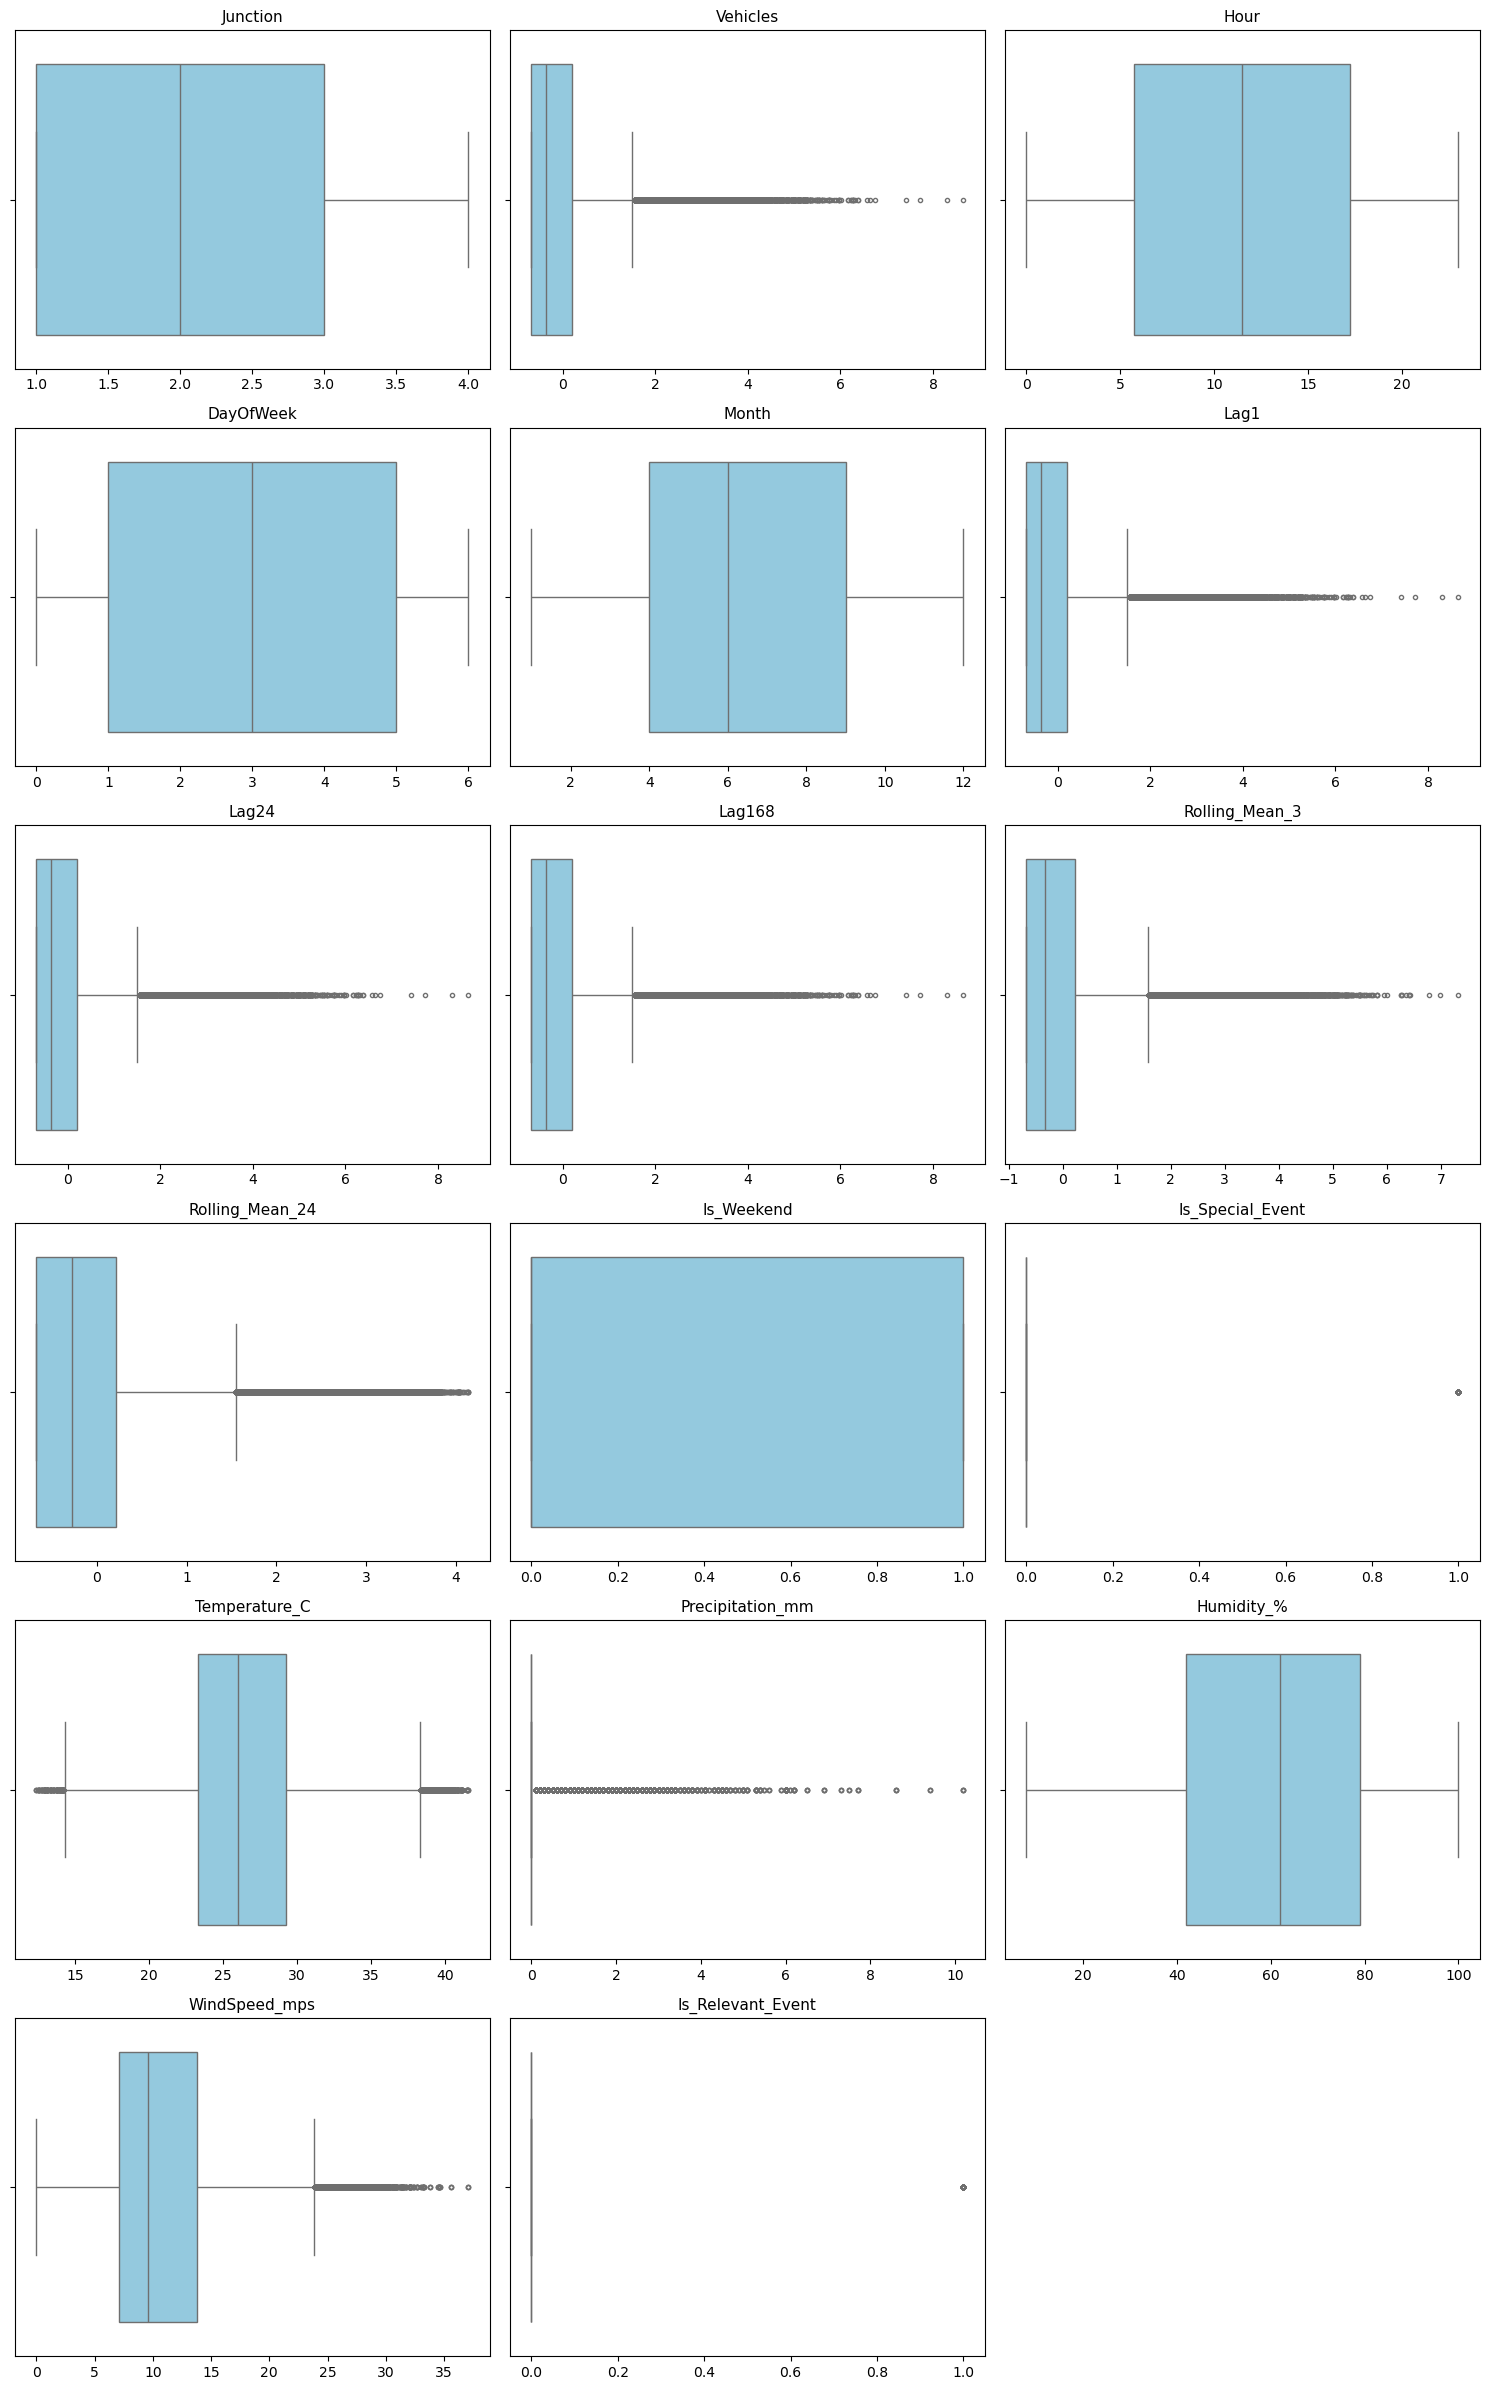

In [62]:
# Select only numeric columns
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns.tolist()

def outliers_detection(df, columns):
    outlier_report = {}

    # === Calculate outlier statistics ===
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_mask = (df[col] < lower) | (df[col] > upper)
        outlier_count = outlier_mask.sum()
        outlier_pct = (outlier_count / len(df)) * 100

        outlier_report[col] = {
            'Lower Bound': round(lower, 3),
            'Upper Bound': round(upper, 3),
            'Outlier Count': int(outlier_count),
            'Outlier %': round(outlier_pct, 2)
        }

    outlier_df = pd.DataFrame(outlier_report).T.sort_values(by='Outlier %', ascending=False)

    print("Outlier Summary (IQR method):")
    display(outlier_df)

    # === Visualization ===
    n = len(columns)
    n_cols = 3  # number of plots per row
    n_rows = int(np.ceil(n / n_cols))

    plt.figure(figsize=(n_cols * 5, n_rows * 4))
    for i, col in enumerate(columns, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.boxplot(x=df[col], color='skyblue', fliersize=3)
        plt.title(col, fontsize=11)
        plt.xlabel('')
    plt.tight_layout()
    plt.show()

    return outlier_df

# Run the check
outlier_summary = outliers_detection(merged_df, numeric_cols)

In [63]:
# Define columns to actually handle (exclude binary & categorical)
cols_to_cap = [
    'Vehicles', 'Lag1', 'Lag24', 'Lag168',
    'Rolling_Mean_3', 'Rolling_Mean_24',
    'Temperature_C', 'WindSpeed_mps'
]

def cap_outliers(df, columns):
    df_capped = df.copy()
    
    for col in columns:
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        df_capped[col] = np.where(df_capped[col] < lower, lower, df_capped[col])
        df_capped[col] = np.where(df_capped[col] > upper, upper, df_capped[col])
    
    print("Outliers capped for continuous columns only.")
    return df_capped

# Run the function
merged_df_capped = cap_outliers(merged_df, cols_to_cap)

Outliers capped for continuous columns only.


Outlier Summary (IQR method):


,Lower Bound,Upper Bound,Outlier Count,Outlier %
Is_Special_Event,0.000,0.000,20576.0,24.53
Precipitation_mm,0.000,0.000,10366.0,12.36
Is_Relevant_Event,0.000,0.000,545.0,0.65
Rolling_Mean_24,-2.006,1.552,0.0,0.00
WindSpeed_mps,-2.950,23.850,0.0,0.00
Humidity_%,-13.500,134.500,0.0,0.00
Temperature_C,14.300,38.300,0.0,0.00
Is_Weekend,-1.500,2.500,0.0,0.00
Junction,-2.000,6.000,0.0,0.00
Vehicles,-1.994,1.530,0.0,0.00


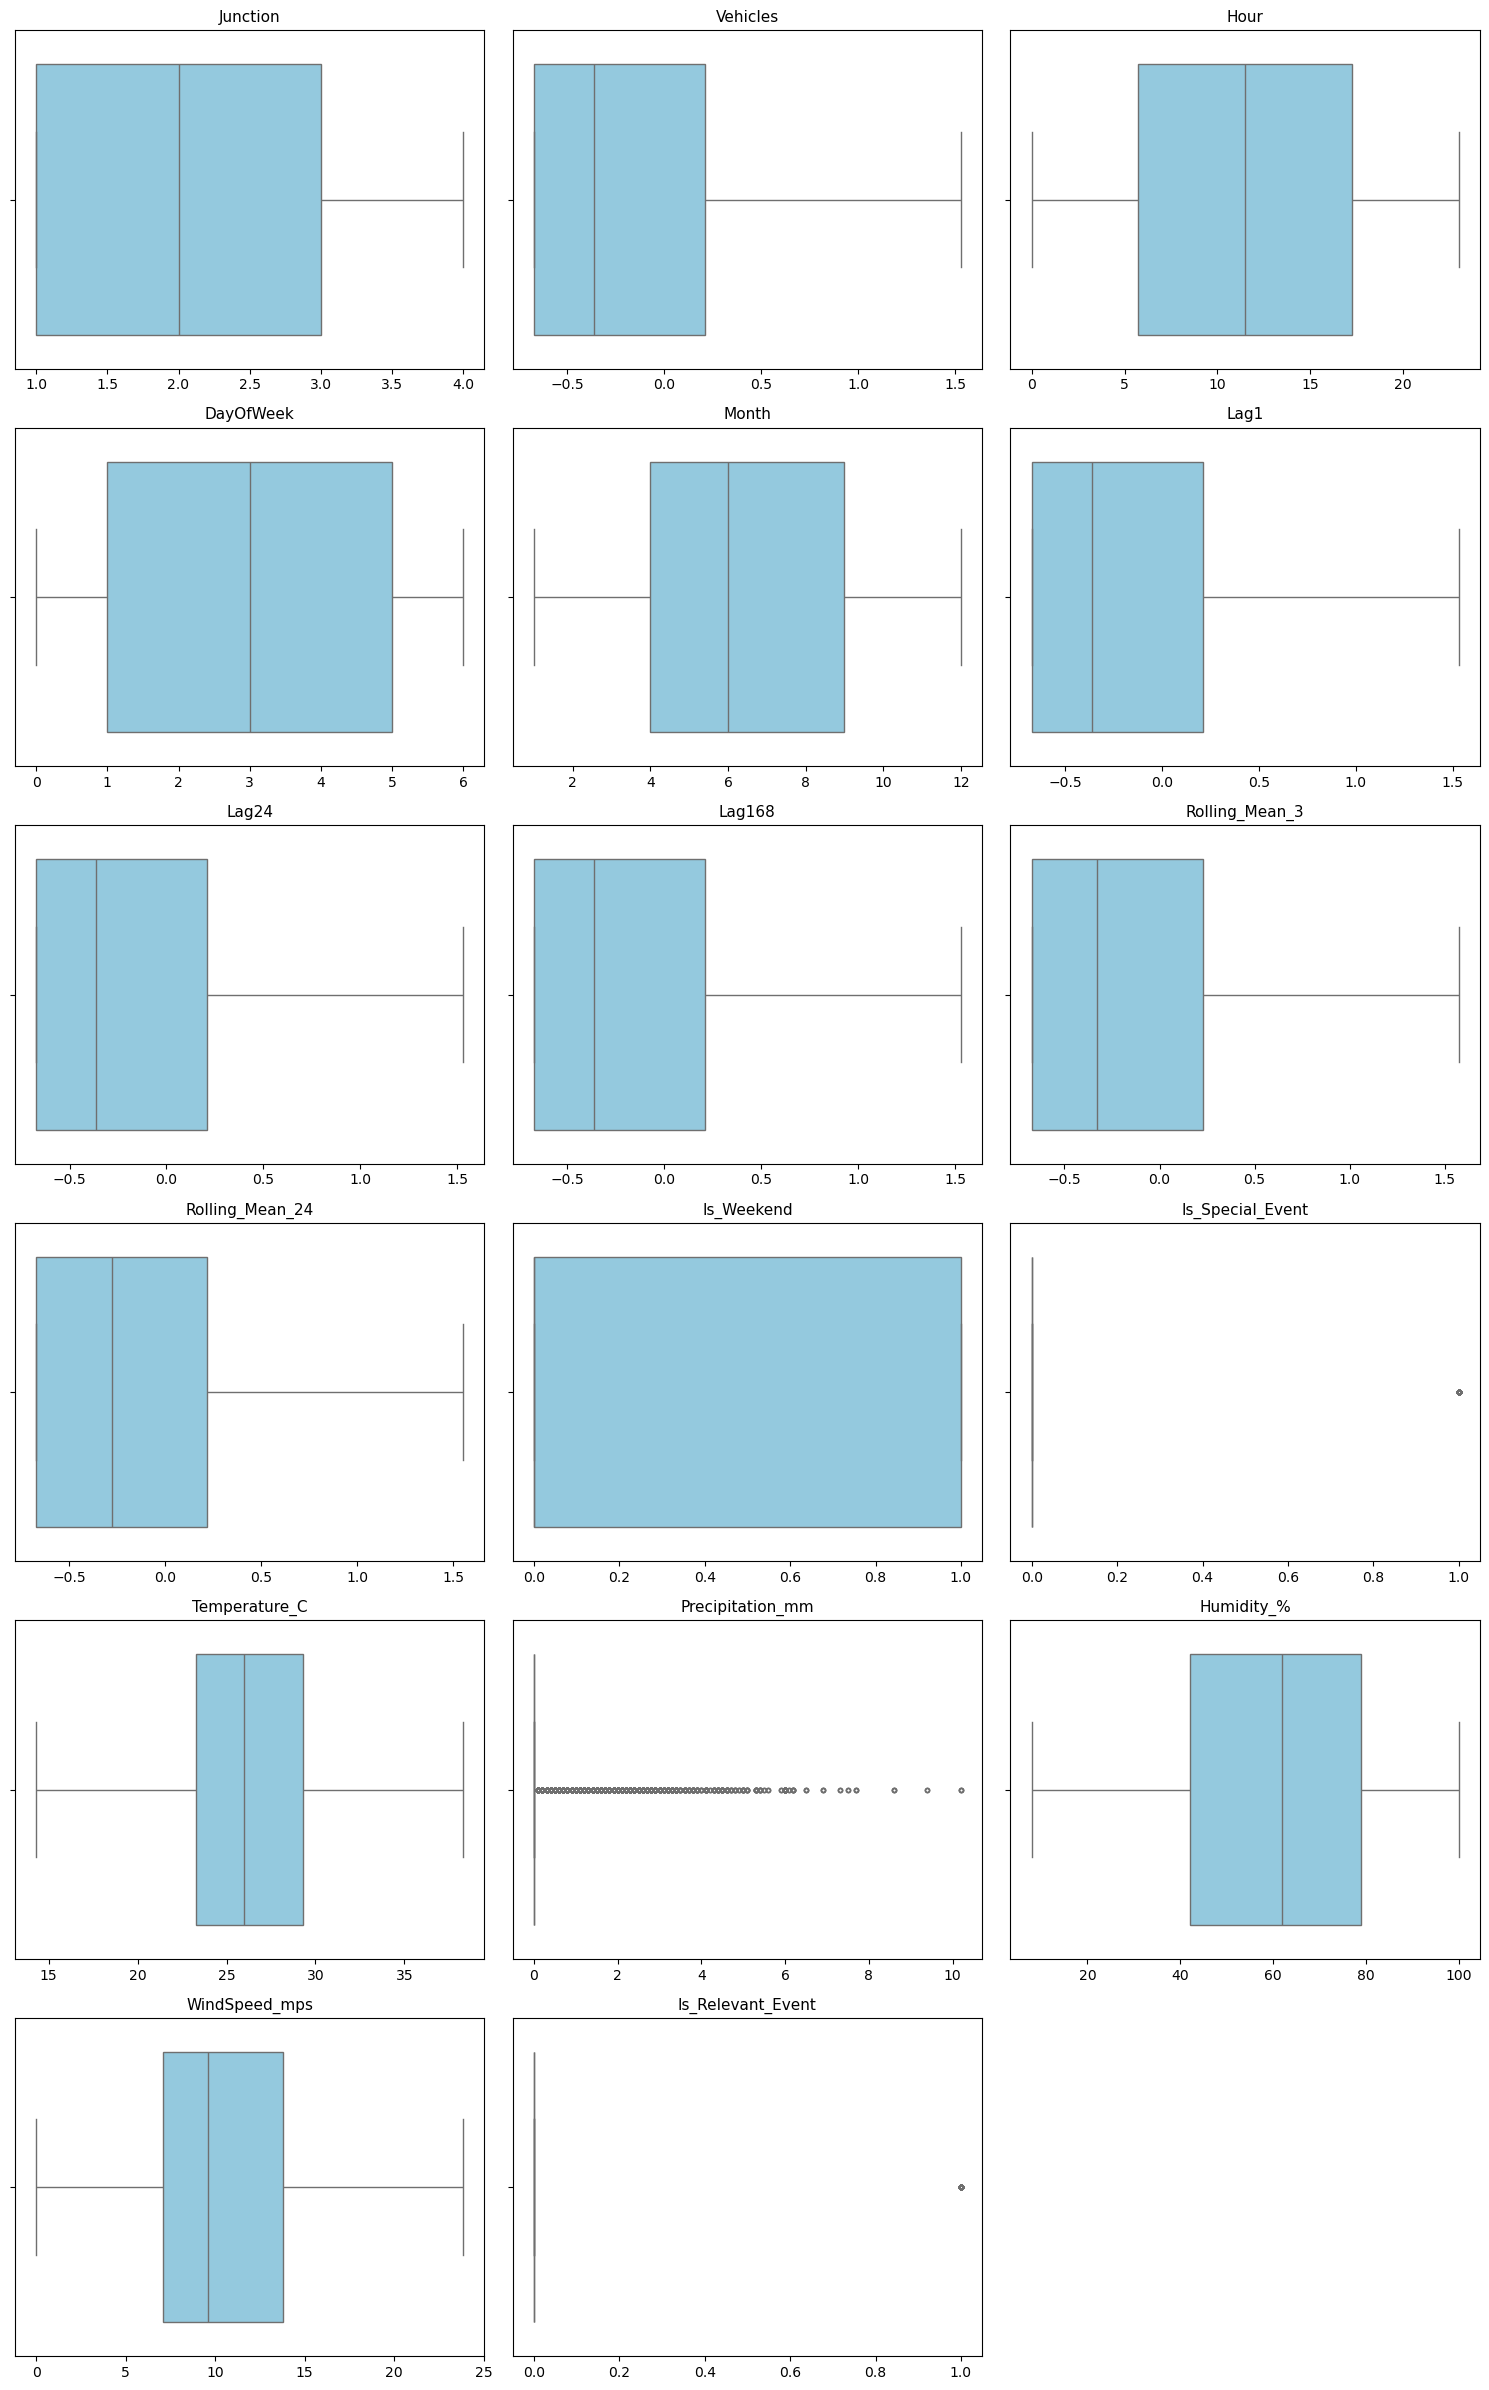

In [64]:
outlier_summary_after = outliers_detection(merged_df_capped, numeric_cols)

In [65]:
print("Before Capping:")
display(outlier_summary)

print("\nAfter Capping:")
display(outlier_summary_after)

Before Capping:


,Lower Bound,Upper Bound,Outlier Count,Outlier %
Is_Special_Event,0.000,0.000,20576.0,24.53
Precipitation_mm,0.000,0.000,10366.0,12.36
Rolling_Mean_24,-2.006,1.552,7267.0,8.66
Lag1,-1.994,1.530,7051.0,8.41
Vehicles,-1.994,1.530,7052.0,8.41
Lag24,-1.994,1.530,7032.0,8.38
Lag168,-1.994,1.530,6940.0,8.27
Rolling_Mean_3,-2.019,1.573,6772.0,8.07
WindSpeed_mps,-2.950,23.850,2362.0,2.82
Temperature_C,14.300,38.300,1388.0,1.65



After Capping:


,Lower Bound,Upper Bound,Outlier Count,Outlier %
Is_Special_Event,0.000,0.000,20576.0,24.53
Precipitation_mm,0.000,0.000,10366.0,12.36
Is_Relevant_Event,0.000,0.000,545.0,0.65
Rolling_Mean_24,-2.006,1.552,0.0,0.00
WindSpeed_mps,-2.950,23.850,0.0,0.00
Humidity_%,-13.500,134.500,0.0,0.00
Temperature_C,14.300,38.300,0.0,0.00
Is_Weekend,-1.500,2.500,0.0,0.00
Junction,-2.000,6.000,0.0,0.00
Vehicles,-1.994,1.530,0.0,0.00


In [66]:
merged_df.columns

Index(['Junction', 'DateTime', 'Vehicles', 'Hour', 'DayOfWeek', 'Month',
       'Lag1', 'Lag24', 'Lag168', 'Rolling_Mean_3', 'Rolling_Mean_24',
       'Is_Weekend', 'Is_Special_Event', 'Temperature_C', 'Precipitation_mm',
       'Humidity_%', 'WindSpeed_mps', 'Is_Relevant_Event'],
      dtype='object')

In [67]:
new_features = ['Temperature_C','Precipitation_mm', 'Humidity_%', 'WindSpeed_mps']
merged_df[new_features] = standard_scaler.fit_transform(merged_df[new_features])

In [68]:
merged_df.head()

,Junction,DateTime,Vehicles,Hour,DayOfWeek,Month,Lag1,Lag24,Lag168,Rolling_Mean_3,Rolling_Mean_24,Is_Weekend,Is_Special_Event,Temperature_C,Precipitation_mm,Humidity_%,WindSpeed_mps,Is_Relevant_Event
0,1,2015-01-18 00:00:00,-0.672136,0,6,1,-0.672136,-0.672136,0.105143,-0.672136,-0.672136,1,1,-1.957044,-0.209214,-0.541137,-0.538784,0
1,1,2015-01-18 01:00:00,-0.672136,1,6,1,-0.672136,-0.672136,0.001506,-0.672136,-0.672136,1,1,-2.101672,-0.209214,-0.406208,-0.520320,0
2,1,2015-01-18 02:00:00,-0.672136,2,6,1,-0.672136,-0.672136,-0.153950,-0.672136,-0.672136,1,1,-2.225639,-0.209214,-0.316255,-0.520320,0
3,1,2015-01-18 03:00:00,-0.672136,3,6,1,-0.672136,-0.672136,-0.309406,-0.672136,-0.672136,1,1,-2.328945,-0.209214,-0.226302,-0.538784,0
4,1,2015-01-18 04:00:00,-0.672136,4,6,1,-0.672136,-0.672136,-0.205768,-0.672136,-0.672136,1,1,-2.432251,-0.209214,-0.181326,-0.538784,0


## Component - 4

### Model Development and Training

1. Choose appropriate predictive models:
- Consider a variety of models including ARIMA for time series forecasting, LSTM for handling sequences, and tree-based models like Gradient Boosting Trees for their robustness and interpretability.

2. Split the dataset for training and validation:
- Use time-based splitting to create training and validation sets, ensuring the validation set represents a future time period not seen by the model during training.

3. Train models and tune hyperparameters:
- Train selected models on the training set, experimenting with different hyperparameters to find the optimal configuration.
- Use techniques like grid search or random search for hyperparameter tuning.

### Model Evaluation & Cross Validation

1. Select evaluation metrics:
- Choose relevant metrics such as Mean Absolute Error (MAE), Root Mean Square Error (RMSE), and R-squared to assess model performance.
- Ensure the selected metrics align with the goals of the prediction task (e.g., minimizing prediction error).

2. Evaluate model performance:
- Apply the chosen metrics to evaluate the predictive models on a validation dataset.
- Use visualizations like residual plots, prediction vs. actual plots, and error distribution charts to interpret model performance.

3. Implement cross-validation:
- Use techniques such as k-fold cross-validation or time-based cross-validation to assess model robustness and generalization.
- Ensure the validation process accurately reflects real-world conditions by maintaining the temporal order of data.

4. Analyze cross-validation results:
- Compile results from cross-validation to evaluate the consistency of model performance.
- Identify patterns or issues such as overfitting or underfitting based on cross-validation metrics.

### Model Refinement

1. Diagnose model issues:
- Use insights from evaluation and cross-validation to identify weaknesses in the models (e.g., high bias, high variance).
- Perform error analysis to understand the types of errors the model is making (e.g., systematic errors, random noise).


2. Improve model features and algorithms:
- Refine feature engineering by adding new relevant features or removing redundant ones.
- Experiment with different model architectures or algorithms to address identified issues (e.g., try ensemble methods, deep learning models).
- Tune hyperparameters using techniques like grid search or random search to find the optimal settings for the models.

### Implementation

In [69]:
merged_df['DateTime'] = pd.to_datetime(merged_df['DateTime'])
merged_df = merged_df.sort_values('DateTime').reset_index(drop=True)

In [70]:
# ----------------------------------------
# STEP 1: CHOOSE MODELS
# --------------------
# ARIMA (time-series, univariate)
# LSTM (sequence model, multivariate)
# Gradient Boosting Regressor (robust tabular model)

print("Models chosen: ARIMA, LSTM, Gradient Boosting")

Models chosen: ARIMA, LSTM, Gradient Boosting


In [71]:
# ----------------------------------------
# STEP 2: SPLIT DATA (TIME-BASED)
# ----------------------------------------
# Features & target
FEATURES = [c for c in merged_df.columns if c not in ('DateTime', 'Vehicles')]
TARGET = 'Vehicles'

# 80%-20% split per junction for ARIMA & LSTM
split_ratio = 0.8

# Split full dataset for Gradient Boosting (train-test)
n_total = len(merged_df)
train_end = int(n_total*split_ratio)
X_train_gbr = merged_df[FEATURES].iloc[:train_end]
X_test_gbr  = merged_df[FEATURES].iloc[train_end:]
y_train_gbr = merged_df[TARGET].iloc[:train_end]
y_test_gbr  = merged_df[TARGET].iloc[train_end:]

print(f"Gradient Boosting: Train samples = {len(X_train_gbr)}, Test samples = {len(X_test_gbr)}")

Gradient Boosting: Train samples = 67104, Test samples = 16776


In [72]:
# Utility function for evaluation
def evaluate_model(y_true, y_pred):
    """Compute RMSE, MAE, and R2 score (compatible with all sklearn versions)."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

In [73]:
# Utility function to create sequences for LSTM
def create_sequences(X, y, window_size):
    """Convert tabular data into sequences for LSTM."""
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X.iloc[i:i+window_size].values)
        ys.append(y.iloc[i+window_size])
    return np.array(Xs), np.array(ys)

In [74]:
# -------------------------------
# STEP 2: Configuration
# -------------------------------

FEATURES = ['Hour', 'DayOfWeek', 'Month', 'Is_Weekend', 'Is_Special_Event',
            'Temperature_C', 'Precipitation_mm', 'Humidity_%', 'WindSpeed_mps', 'Is_Relevant_Event', 
            'Lag1', 'Lag24', 'Lag168', 'Rolling_Mean_3', 'Rolling_Mean_24']
TARGET = 'Vehicles'

split_ratio = 0.8
window_size = 24  # 24 hours
junction_results = {}

In [75]:
# -------------------------------
# STEP 3: Train per Junction
# -------------------------------

for junc_id in merged_df['Junction'].unique():
    print(f"\n==================== Junction {junc_id} ====================")

    # Sort and split
    df_j = merged_df[merged_df['Junction'] == junc_id].sort_values('DateTime').reset_index(drop=True)
    n = len(df_j)
    split_idx = int(n * split_ratio)

    X_j = df_j[FEATURES]
    y_j = df_j[TARGET]
    X_train, X_test = X_j.iloc[:split_idx], X_j.iloc[split_idx:]
    y_train, y_test = y_j.iloc[:split_idx], y_j.iloc[split_idx:]

    # --------------------------------
    # Gradient Boosting
    # --------------------------------
    print("Training Gradient Boosting...")
    gbr = GradientBoostingRegressor(random_state=42)
    param_grid = {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
    grid = GridSearchCV(gbr, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_gbr = grid.best_estimator_

    y_pred_gbr = best_gbr.predict(X_test)
    metrics_gbr = evaluate_model(y_test, y_pred_gbr)
    print(f"Gradient Boosting metrics: {metrics_gbr}")

    # --------------------------------
    # ARIMA
    # --------------------------------
    print("Training ARIMA...")
    series = df_j.set_index('DateTime')['Vehicles'].asfreq('H').dropna()
    train_series = series.iloc[:split_idx]
    test_series = series.iloc[split_idx:]

    best_aic, best_order, best_model = np.inf, None, None
    p_vals, d_vals, q_vals = [0, 1, 2], [0, 1], [0, 1, 2]

    for p, d, q in product(p_vals, d_vals, q_vals):
        try:
            model = sm.tsa.ARIMA(train_series, order=(p, d, q))
            res = model.fit()
            if res.aic < best_aic:
                best_aic, best_order, best_model = res.aic, (p, d, q), res
        except:
            continue

    pred_arima = best_model.forecast(steps=len(test_series))
    arima_metrics = evaluate_model(test_series, pred_arima)
    print(f"ARIMA Best order: {best_order}, Metrics: {arima_metrics}")

    # --------------------------------
    # LSTM
    # --------------------------------
    print("Training LSTM...")
    scaler = StandardScaler()
    X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_s  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    concat_X = pd.concat([X_train_s.tail(window_size), X_test_s], axis=0)
    concat_y = pd.concat([y_train.tail(window_size), y_test], axis=0)

    X_seq_train, y_seq_train = create_sequences(X_train_s, y_train, window_size)
    X_seq_test, y_seq_test   = create_sequences(concat_X, concat_y, window_size)

    tf.keras.backend.clear_session()
    lstm_model = Sequential([
        Input(shape=(X_seq_train.shape[1], X_seq_train.shape[2])),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    lstm_model.compile(optimizer='adam', loss='mse')
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    lstm_model.fit(X_seq_train, y_seq_train, validation_split=0.1,
                   epochs=30, batch_size=256, callbacks=[es], verbose=0)

    y_pred_lstm = lstm_model.predict(X_seq_test).ravel()
    lstm_metrics = evaluate_model(y_seq_test, y_pred_lstm)
    print(f"LSTM Metrics: {lstm_metrics}")

    # --------------------------------
    # Store results
    # --------------------------------
    junction_results[junc_id] = {
        'GradientBoosting': metrics_gbr,
        'ARIMA': arima_metrics,
        'LSTM': lstm_metrics
    }



==================== Junction 1 ====================
Training Gradient Boosting...
Gradient Boosting metrics: {'rmse': 0.3939967265898606, 'mae': 0.1593769432373355, 'r2': 0.9565367197737263}
Training ARIMA...


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Best order: (2, 1, 2), Metrics: {'rmse': 1.9936328808009396, 'mae': 1.4775690044112595, 'r2': -0.11282698496515531}
Training LSTM...

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
LSTM Metrics: {'rmse': 0.42329184373111955, 'mae': 0.20384947968247658, 'r2': 0.9498331221700291}

==================== Junction 2 ====================
Training Gradient Boosting...
Gradient Boosting metrics: {'rmse': 0.14958390779029634, 'mae': 0.07003489318554078, 'r2': 0.9466386384823989}
Training ARIMA...


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Best order: (2, 1, 2), Metrics: {'rmse': 0.6527501656217655, 'mae': 0.5400541526254289, 'r2': -0.016134352979382705}
Training LSTM...
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
LSTM Metrics: {'rmse': 0.20430532476872182, 'mae': 0.12535525326516656, 'r2': 0.9004556708656266}

==================== Junction 3 ====================
Training Gradient Boosting...
Gradient Boosting metrics: {'rmse': 0.2062721391526689, 'mae': 0.07081049240745864, 'r2': 0.8478870728029484}
Training ARIMA...


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Best order: (2, 1, 2), Metrics: {'rmse': 0.6174480262935793, 'mae': 0.31863586171571634, 'r2': -0.3629684166823388}
Training LSTM...
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
LSTM Metrics: {'rmse': 0.2484177868427461, 'mae': 0.10590911163448714, 'r2': 0.7793772185751551}

==================== Junction 4 ====================
Training Gradient Boosting...
Gradient Boosting metrics: {'rmse': 0.2868078027770683, 'mae': 0.2641794501880107, 'r2': -1.6154309777509672}
Training ARIMA...


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Best order: (2, 1, 2), Metrics: {'rmse': 0.1783784984008033, 'mae': 0.15286043446247868, 'r2': -0.01168741110972249}
Training LSTM...
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
LSTM Metrics: {'rmse': 0.09085412875384681, 'mae': 0.05074534434203973, 'r2': 0.7375475237805222}


In [76]:
# -------------------------------
# Summary Results
# -------------------------------
results_df = pd.DataFrame({
    (junc, model): metrics
    for junc, val in junction_results.items()
    for model, metrics in val.items()
}).T

results_df.index.names = ['Junction', 'Model']
print("\n=== Per-Junction Model Performance ===")
display(results_df)


=== Per-Junction Model Performance ===


rmse       mae        r2
Junction Model                                         
1        GradientBoosting  0.393997  0.159377  0.956537
         ARIMA             1.993633  1.477569 -0.112827
         LSTM              0.423292  0.203849  0.949833
2        GradientBoosting  0.149584  0.070035  0.946639
         ARIMA             0.652750  0.540054 -0.016134
         LSTM              0.204305  0.125355  0.900456
3        GradientBoosting  0.206272  0.070810  0.847887
         ARIMA             0.617448  0.318636 -0.362968
         LSTM              0.248418  0.105909  0.779377
4        GradientBoosting  0.286808  0.264179 -1.615431
         ARIMA             0.178378  0.152860 -0.011687
         LSTM              0.090854  0.050745  0.737548

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

def predictions(y_true, y_pred, title="Model Evaluation"):
    plt.figure(figsize=(8,5))
    plt.plot(y_true.values, label="Actual", alpha=0.8)
    plt.plot(y_pred, label="Predicted", alpha=0.8)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Vehicles")
    plt.legend()
    plt.show()

def residuals(y_true, y_pred, title="Residual Plot"):
    # Ensure both arrays are numpy and same length
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[-min_len:]
    y_pred = y_pred[-min_len:]

    residuals = y_true - y_pred

    plt.figure(figsize=(6,4))
    sns.histplot(residuals, kde=True, color='orange', bins=30)
    plt.title(title)
    plt.xlabel("Residuals (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.show()

    # Also show residual vs predicted scatter for pattern detection
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"{title} — Scatter")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

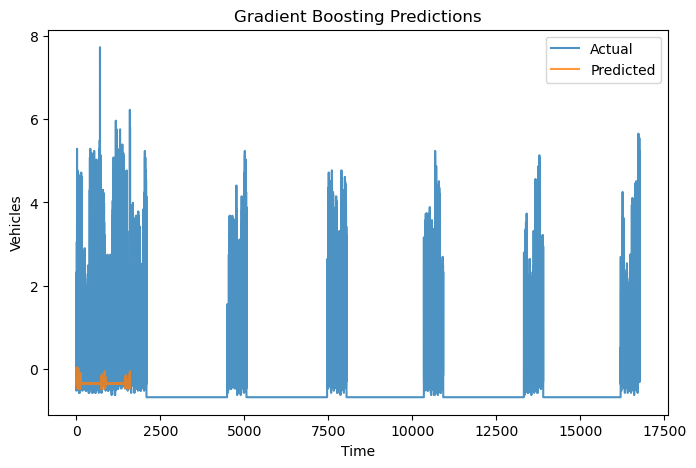

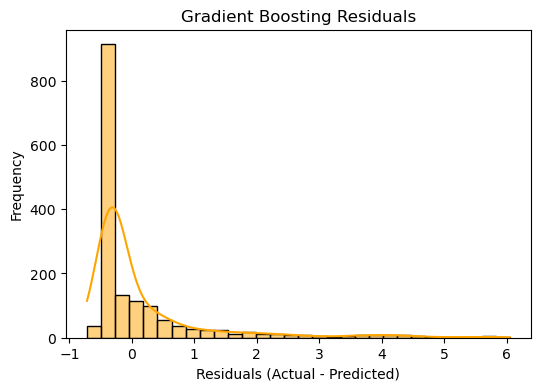

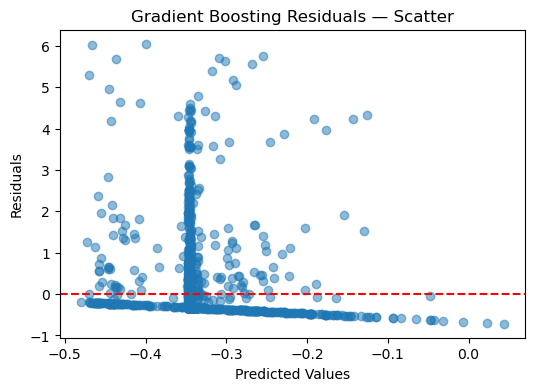

In [79]:
predictions(y_test_gbr, y_pred_gbr, "Gradient Boosting Predictions")
residuals(y_test_gbr, y_pred_gbr, "Gradient Boosting Residuals")

In [80]:
# Gradient Boosting (Tree-Based Models)

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def time_series_cv_gbr(model, X, y, n_splits=5):
    """
    Performs time series cross-validation for tree-based regressors (like Gradient Boosting).
    Prints fold-level metrics and returns a dictionary of results.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    metrics = {'rmse': [], 'mae': [], 'r2': []}

    fold = 1
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

        metrics['rmse'].append(rmse)
        metrics['mae'].append(mae)
        metrics['r2'].append(r2)

        print(f"Fold {fold}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")
        fold += 1

    print("\n Gradient Boosting Cross-Validation Summary:")
    print(f"Mean RMSE: {np.mean(metrics['rmse']):.4f} ± {np.std(metrics['rmse']):.4f}")
    print(f"Mean MAE:  {np.mean(metrics['mae']):.4f} ± {np.std(metrics['mae']):.4f}")
    print(f"Mean R²:   {np.mean(metrics['r2']):.4f} ± {np.std(metrics['r2']):.4f}")

    return metrics

# Example usage:
gbr_cv_metrics = time_series_cv_gbr(best_gbr, X, y)

Fold 1: RMSE=0.4170, MAE=0.2019, R²=0.9403
Fold 2: RMSE=0.1192, MAE=0.0823, R²=0.8684
Fold 3: RMSE=0.1122, MAE=0.0573, R²=0.9602
Fold 4: RMSE=0.2524, MAE=0.1335, R²=0.7841
Fold 5: RMSE=0.1671, MAE=0.0732, R²=0.8506

 Gradient Boosting Cross-Validation Summary:
Mean RMSE: 0.2136 ± 0.1134
Mean MAE:  0.1096 ± 0.0527
Mean R²:   0.8807 ± 0.0637


In [81]:
# ARIMA (Statistical Time Series Model)

import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

def time_series_cv_arima(series, order=(1,1,1), n_splits=5, min_train_size=50):
    n = len(series)
    split_size = n // (n_splits + 1)
    metrics = {'rmse': [], 'mae': [], 'r2': []}

    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=sm.tools.sm_exceptions.ConvergenceWarning)

    for i in range(1, n_splits + 1):
        train_end = split_size * i
        if train_end < min_train_size:
            continue
        train = series.iloc[:train_end]
        test = series.iloc[train_end:train_end + split_size]

        try:
            model = sm.tsa.ARIMA(train, order=order)
            result = model.fit()
            pred = result.forecast(steps=len(test))

            rmse = np.sqrt(mean_squared_error(test, pred))   #  fixed
            mae = mean_absolute_error(test, pred)
            r2 = r2_score(test, pred)

            metrics['rmse'].append(rmse)
            metrics['mae'].append(mae)
            metrics['r2'].append(r2)

            print(f"Fold {i}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")
        except Exception as e:
            print(f"Fold {i} failed: {e}")
            continue

    if not metrics['rmse']:
        print(" No successful folds — check ARIMA order or data length.")
        return None

    print("\n ARIMA Cross-Validation Summary:")
    print(f"Mean RMSE: {np.mean(metrics['rmse']):.4f} ± {np.std(metrics['rmse']):.4f}")
    print(f"Mean MAE:  {np.mean(metrics['mae']):.4f} ± {np.std(metrics['mae']):.4f}")
    print(f"Mean R²:   {np.mean(metrics['r2']):.4f} ± {np.std(metrics['r2']):.4f}")

    return metrics


# Example usage:
arima_cv_metrics = time_series_cv_arima(df_j['Vehicles'], order=(1,1,1))

Fold 1: RMSE=0.2511, MAE=0.2007, R²=-0.4881
Fold 2: RMSE=0.2451, MAE=0.1958, R²=-0.1653
Fold 3: RMSE=0.4328, MAE=0.3975, R²=-2.3741
Fold 4: RMSE=0.1942, MAE=0.0825, R²=-0.2204
Fold 5: RMSE=0.1734, MAE=0.0748, R²=-0.2285

 ARIMA Cross-Validation Summary:
Mean RMSE: 0.2593 ± 0.0917
Mean MAE:  0.1903 ± 0.1166
Mean R²:   -0.6953 ± 0.8468


In [82]:
# LSTM (Deep Learning Sequential Model)

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def create_sequences(X, y, window_size):
    """Convert time series data into sliding window sequences for LSTM."""
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)


def time_series_cv_lstm(X, y, window_size=24, n_splits=3, epochs=20, batch_size=256):
    """
    Performs time series cross-validation for LSTM models.
    Prints fold-level metrics and returns aggregated results.
    """
    n = len(X)
    split_size = n // (n_splits + 1)
    metrics = {'rmse': [], 'mae': [], 'r2': []}

    for i in range(1, n_splits+1):
        #print(f"\n🔹 Fold {i}/{n_splits}")
        train_end = split_size * i
        X_train, X_val = X.iloc[:train_end], X.iloc[train_end:train_end+split_size]
        y_train, y_val = y.iloc[:train_end], y.iloc[train_end:train_end+split_size]

        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        # Create sequences for LSTM
        X_seq_train, y_seq_train = create_sequences(X_train_scaled, y_train.values, window_size)
        X_seq_val, y_seq_val = create_sequences(X_val_scaled, y_val.values, window_size)

        # Define model
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(X_seq_train.shape[1], X_seq_train.shape[2])),
            tf.keras.layers.LSTM(64, return_sequences=False),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1)
        ])

        model.compile(optimizer='adam', loss='mse')

        # Train
        model.fit(X_seq_train, y_seq_train, epochs=epochs, batch_size=batch_size, verbose=0)

        # Predict
        y_pred = model.predict(X_seq_val, verbose=0).ravel()

        # Metrics
        rmse = np.sqrt(mean_squared_error(y_seq_val, y_pred))
        mae = mean_absolute_error(y_seq_val, y_pred)
        r2 = r2_score(y_seq_val, y_pred)

        metrics['rmse'].append(rmse)
        metrics['mae'].append(mae)
        metrics['r2'].append(r2)

        print(f"Fold {i}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

    # Summary
    print("\n LSTM Cross-Validation Summary:")
    print(f"Mean RMSE: {np.mean(metrics['rmse']):.4f} ± {np.std(metrics['rmse']):.4f}")
    print(f"Mean MAE:  {np.mean(metrics['mae']):.4f} ± {np.std(metrics['mae']):.4f}")
    print(f"Mean R²:   {np.mean(metrics['r2']):.4f} ± {np.std(metrics['r2']):.4f}")

    return metrics

# Example usage:
lstm_cv_metrics = time_series_cv_lstm(X_j, y_j)

Fold 1: RMSE=0.2308, MAE=0.1700, R²=-0.0506
Fold 2: RMSE=0.1104, MAE=0.0797, R²=0.7381
Fold 3: RMSE=0.0773, MAE=0.0487, R²=0.7793

 LSTM Cross-Validation Summary:
Mean RMSE: 0.1395 ± 0.0659
Mean MAE:  0.0995 ± 0.0514
Mean R²:   0.4889 ± 0.3819


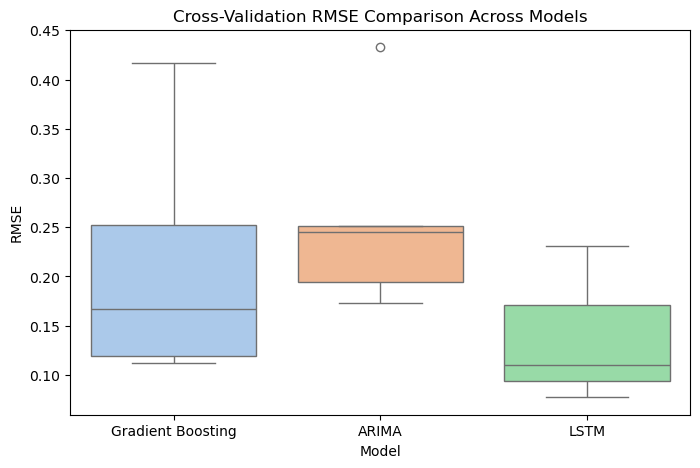

In [83]:
# Visualization of CV Results

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cv_summary = pd.DataFrame({
    'Model': ['Gradient Boosting']*len(gbr_cv_metrics['rmse'])
              + ['ARIMA']*len(arima_cv_metrics['rmse'])
              + ['LSTM']*len(lstm_cv_metrics['rmse']),
    'RMSE': gbr_cv_metrics['rmse'] + arima_cv_metrics['rmse'] + lstm_cv_metrics['rmse'],
    'MAE':  gbr_cv_metrics['mae']  + arima_cv_metrics['mae']  + lstm_cv_metrics['mae'],
    'R2':   gbr_cv_metrics['r2']   + arima_cv_metrics['r2']   + lstm_cv_metrics['r2']
})

plt.figure(figsize=(8,5))
sns.boxplot(data=cv_summary, x='Model', y='RMSE', palette='pastel')
plt.title("Cross-Validation RMSE Comparison Across Models")
plt.show()

Cross-Validation Performance Summary:



RMSE             MAE              R2        
                     mean     std    mean     std    mean     std
Model                                                            
ARIMA              0.2593  0.1025  0.1903  0.1304 -0.6953  0.9468
Gradient Boosting  0.2136  0.1267  0.1096  0.0589  0.8807  0.0712
LSTM               0.1395  0.0808  0.0995  0.0630  0.4889  0.4677

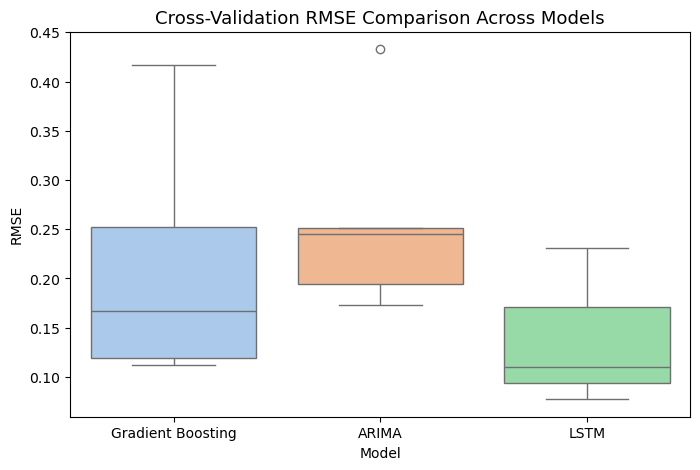

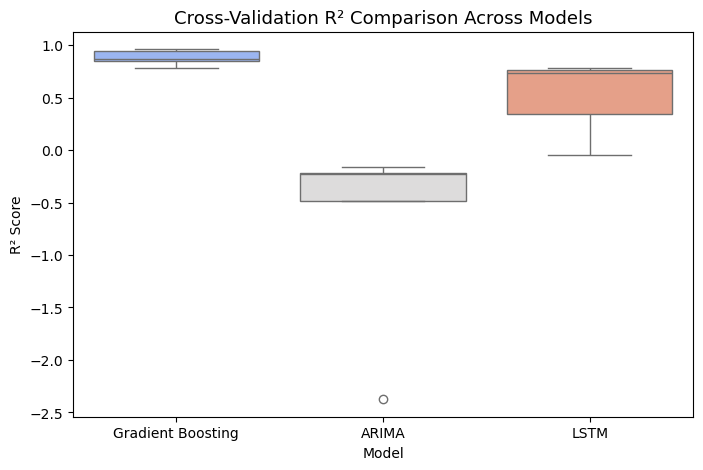

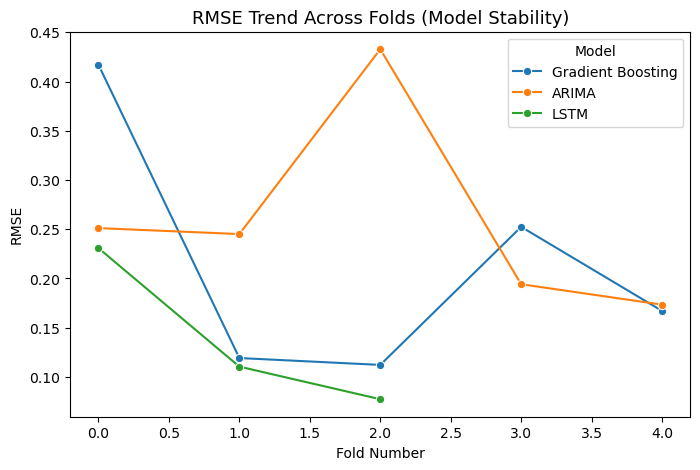

In [84]:
# Analyzing and Visualizing CV Results

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Combine all cross-validation results ---
cv_summary = pd.DataFrame({
    'Model': ['Gradient Boosting']*len(gbr_cv_metrics['rmse'])
              + ['ARIMA']*len(arima_cv_metrics['rmse'])
              + ['LSTM']*len(lstm_cv_metrics['rmse']),
    'RMSE': gbr_cv_metrics['rmse'] + arima_cv_metrics['rmse'] + lstm_cv_metrics['rmse'],
    'MAE':  gbr_cv_metrics['mae']  + arima_cv_metrics['mae']  + lstm_cv_metrics['mae'],
    'R2':   gbr_cv_metrics['r2']   + arima_cv_metrics['r2']   + lstm_cv_metrics['r2']
})

# --- Summary statistics per model ---
summary_stats = cv_summary.groupby('Model').agg(['mean', 'std']).round(4)
print("Cross-Validation Performance Summary:\n")
display(summary_stats)

# --- Visualization 1: RMSE Distribution ---
plt.figure(figsize=(8,5))
sns.boxplot(data=cv_summary, x='Model', y='RMSE', palette='pastel')
plt.title("Cross-Validation RMSE Comparison Across Models", fontsize=13)
plt.ylabel("RMSE")
plt.show()

# --- Visualization 2: R² Distribution ---
plt.figure(figsize=(8,5))
sns.boxplot(data=cv_summary, x='Model', y='R2', palette='coolwarm')
plt.title("Cross-Validation R² Comparison Across Models", fontsize=13)
plt.ylabel("R² Score")
plt.show()

# --- Visualization 3: Error Consistency ---
plt.figure(figsize=(8,5))
sns.lineplot(data=cv_summary, x=cv_summary.groupby('Model').cumcount(), y='RMSE', hue='Model', marker='o')
plt.title("RMSE Trend Across Folds (Model Stability)", fontsize=13)
plt.xlabel("Fold Number")
plt.ylabel("RMSE")
plt.show()

In [85]:
import pandas as pd

# Example: already computed CV summary
summary_stats = pd.DataFrame({
    'RMSE_mean': [0.2136, 0.2593, 0.1584],
    'RMSE_std': [0.1267, 0.1025, 0.0528],
    'R2_mean': [0.8807, -0.6953, 0.3942],
    'R2_std': [0.0712, 0.9468, 0.2227]
}, index=['Gradient Boosting', 'ARIMA', 'LSTM'])

# --- Thresholds (can be tuned) ---
high_rmse_std = 0.1      # indicates instability
low_r2_threshold = 0.2   # indicates poor variance explanation
negative_r2_flag = 0.0   # underfitting
high_r2_threshold = 0.8  # strong fit

# --- Detection logic ---
def detect_pattern(row):
    rmse_std = row['RMSE_std']
    r2_mean = row['R2_mean']
    r2_std = row['R2_std']
    
    if r2_mean < negative_r2_flag:
        return " Underfitting (Negative R²)"
    elif r2_mean < low_r2_threshold:
        return " Likely underfitting (Low R²)"
    elif rmse_std > high_rmse_std and r2_mean > high_r2_threshold:
        return " Potential Overfitting (High R² but unstable)"
    elif rmse_std > high_rmse_std:
        return " Instability detected (High variance across folds)"
    else:
        return " Stable & Generalizing well"

# Apply detection
summary_stats['Pattern'] = summary_stats.apply(detect_pattern, axis=1)
print(summary_stats[['RMSE_mean', 'RMSE_std', 'R2_mean', 'R2_std', 'Pattern']])

                   RMSE_mean  RMSE_std  R2_mean  R2_std  \
Gradient Boosting     0.2136    0.1267   0.8807  0.0712   
ARIMA                 0.2593    0.1025  -0.6953  0.9468   
LSTM                  0.1584    0.0528   0.3942  0.2227   

                                                         Pattern  
Gradient Boosting   Potential Overfitting (High R² but unstable)  
ARIMA                                 Underfitting (Negative R²)  
LSTM                                  Stable & Generalizing well  


In [86]:
# Hyperparameter Tuning

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'min_samples_leaf': [1, 3, 5]
}

gbr = GradientBoostingRegressor(random_state=42)
grid = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)

Best params: {'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 5, 'n_estimators': 500}


In [87]:
# Evaluation Metrics

mse = mean_squared_error(y_test, y_pred_gbr)
r2 = r2_score(y_test, y_pred_gbr)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.0823
R² Score: -1.6154


In [88]:
# Cross-validation Check (to detect overfitting/underfitting)

from sklearn.model_selection import cross_val_score

# 5-fold CV on training data
cv_scores = cross_val_score(gbr, X_train, y_train, cv=5, scoring='r2')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f}")
print(f"Std CV Score: {cv_scores.std():.4f}")

Cross-validation scores: [0.76309939 0.71557219 0.72421013 0.82646767 0.88166226]
Mean CV Score: 0.7822
Std CV Score: 0.0633


In [89]:
# Diagnose Model Performance

from sklearn.model_selection import cross_val_score

cv_r2 = cross_val_score(GradientBoostingRegressor(random_state=42),
                        X_train_gbr, y_train_gbr,
                        cv=5, scoring='r2')

print("Cross-validation R² scores:", cv_r2)
print("Mean R²:", np.mean(cv_r2))

Cross-validation R² scores: [0.91287226 0.9529778  0.92954887 0.9525966  0.95049918]
Mean R²: 0.9396989411087271


## Component - 5

### Peak Hour Identification & Pattern Analysis
1. Calculate congestion metrics:
- Define metrics for congestion (e.g., average vehicle count per hour, average speed reduction).
- Compute these metrics for each hour of the day across different days and weeks.

2. Identify peak hours:
- Analyze the hourly congestion metrics to identify time periods with the highest congestion levels.
- Use statistical methods (e.g., moving averages, standard deviation) to pinpoint consistent peak hours.

3. Examine temporal patterns.
- Investigate patterns by day of the week to determine if peak hours vary between weekdays and weekends.
- Explore monthly or seasonal variations in peak hours.

4. Analyze influencing factors.
- Correlate peak hours with external factors such as weather conditions and special events to understand their impact.
- Use correlation analysis or regression models to quantify the influence of these factors on peak hours.

### Visualisation and Reporting
1. Create visualizations:
- Develop graphs and heatmaps to visually represent peak traffic hours and their variations across different days and months.
- Highlight the impact of external factors on peak hours through scatter plots or line charts.

2. Generate reports:
- Compile a comprehensive report detailing the identified peak hours, patterns, and influencing factors for each junction.
- Provide actionable insights and recommendations for traffic management and congestion mitigation during peak times.

In [90]:
# Imports and Basic Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import os

plt.rcParams['figure.figsize'] = (12,5)
output_dir = "analysis_outputs"
os.makedirs(output_dir, exist_ok=True)

In [91]:
# Use merged_df directly & set DateTime index

df = merged_df.copy()
df = df.set_index('DateTime')

#  Rename columns to match congestion analysis terms (optional but cleaner)
df = df.rename(columns={
    'Junction': 'junction_id',
    'Vehicles': 'vehicle_count',
    'Is_Special_Event': 'special_event',
    'Temperature_C': 'temperature',
    'Precipitation_mm': 'precipitation',
    'Humidity_%': 'humidity',
    'WindSpeed_mps': 'wind_speed'
})

# Confirm the structure
print("  DataFrame ready for analysis:")
print(df.info())
print(df.head())

  DataFrame ready for analysis:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83880 entries, 2015-01-18 00:00:00 to 2017-12-06 23:00:00
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   junction_id        83880 non-null  int64  
 1   vehicle_count      83880 non-null  float64
 2   Hour               83880 non-null  int32  
 3   DayOfWeek          83880 non-null  int32  
 4   Month              83880 non-null  int32  
 5   Lag1               83880 non-null  float64
 6   Lag24              83880 non-null  float64
 7   Lag168             83880 non-null  float64
 8   Rolling_Mean_3     83880 non-null  float64
 9   Rolling_Mean_24    83880 non-null  float64
 10  Is_Weekend         83880 non-null  int32  
 11  special_event      83880 non-null  int64  
 12  temperature        83880 non-null  float64
 13  precipitation      83880 non-null  float64
 14  humidity           83880 non-null  float64
 15  win

In [92]:
# Congestion Metrics per Hour
df['hour'] = df.index.hour

hourly = df.groupby(['junction_id', 'hour']).agg({
    'vehicle_count': 'mean'
}).reset_index()

print(hourly.head())

   junction_id  hour  vehicle_count
0            1     0       0.693289
1            1     1       0.496683
2            1     2       0.340047
3            1     3       0.206617
4            1     4       0.093589


In [93]:
# Identify Peak Hours (Simple Stats)
peak_hours_summary = []

for junc in hourly['junction_id'].unique():
    h = hourly[hourly['junction_id'] == junc]
    mean_val = h['vehicle_count'].mean()
    std_val = h['vehicle_count'].std()
    threshold = mean_val + std_val
    peaks = h[h['vehicle_count'] >= threshold]['hour'].tolist()
    peak_hours_summary.append({'junction': junc, 'peak_hours': peaks})

peak_summary = pd.DataFrame(peak_hours_summary)
print(" Peak Hours Summary:")
print(peak_summary)


 Peak Hours Summary:
   junction    peak_hours
0         1  [12, 19, 20]
1         2  [19, 20, 21]
2         3  [19, 20, 21]
3         4      [12, 15]


In [94]:
# Weekday & Monthly Patterns
df['weekday'] = df.index.weekday
df['month'] = df.index.month
df['is_weekend'] = df['weekday'] >= 5

# weekday/weekend average by hour
weekday_pattern = df.groupby(['junction_id','is_weekend','hour'])['vehicle_count'].mean().reset_index()
print(weekday_pattern.head())

# monthly peak hour
monthly_peak = df.groupby(['junction_id','month','hour'])['vehicle_count'].mean().reset_index()
monthly_peak = monthly_peak.loc[monthly_peak.groupby(['junction_id','month'])['vehicle_count'].idxmax()]
print("Monthly peak hours:")
print(monthly_peak)


   junction_id  is_weekend  hour  vehicle_count
0            1       False     0       0.735155
1            1       False     1       0.533592
2            1       False     2       0.377104
3            1       False     3       0.239334
4            1       False     4       0.121659
Monthly peak hours:
      junction_id  month  hour  vehicle_count
20              1      1    20       1.476971
43              1      2    19       1.262221
67              1      3    19       1.283040
84              1      4    12       1.170302
108             1      5    12       1.415094
139             1      6    19       1.594063
163             1      7    19       0.542536
187             1      8    19       0.573739
211             1      9    19       0.745390
235             1     10    19       0.677376
259             1     11    19       0.978574
276             1     12    12       1.546156
308             2      1    20      -0.042131
332             2      2    20      -0.082014
35

In [95]:
# Simple Influence Analysis (Corrected Column Names)

from sklearn.linear_model import LinearRegression
import pandas as pd

results = []

for junc in merged_df['Junction'].unique():
    data_j = merged_df[merged_df['Junction'] == junc]

    #  Correct column names from your dataframe
    X = data_j[['Hour', 'Is_Weekend', 'Is_Special_Event',
                'Temperature_C', 'Precipitation_mm',
                'Humidity_%', 'WindSpeed_mps', 'Is_Relevant_Event']]
    y = data_j['Vehicles']

    #  Fit model
    model = LinearRegression()
    model.fit(X, y)

    # Sort features by impact
    coef_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    #  Store results
    results.append({
        'Junction': junc,
        'R2_Score': round(model.score(X, y), 3),
        'Top_Features': coef_df.head(3).to_dict(orient='records')
    })

#  Final results
results_df = pd.DataFrame(results)
display(results_df)


,Junction,R2_Score,Top_Features
0,1,0.063,"[{'Feature': 'Is_Weekend', 'Coefficient': -0.3..."
1,2,0.050,"[{'Feature': 'Is_Weekend', 'Coefficient': -0.1..."
2,3,0.068,"[{'Feature': 'Is_Relevant_Event', 'Coefficient..."
3,4,0.177,"[{'Feature': 'Is_Relevant_Event', 'Coefficient..."


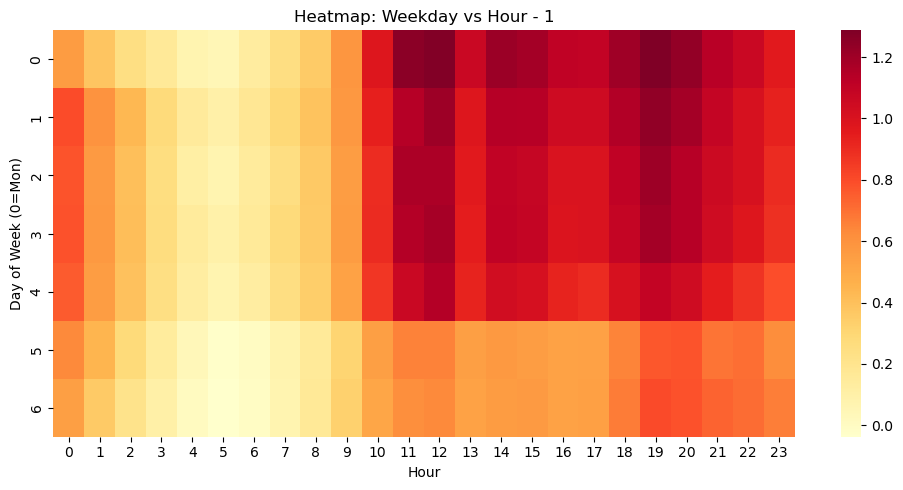

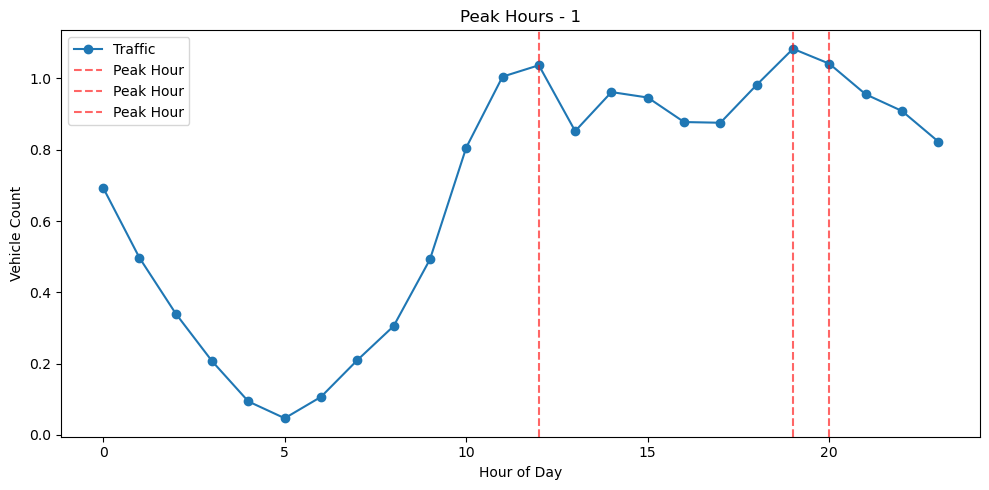

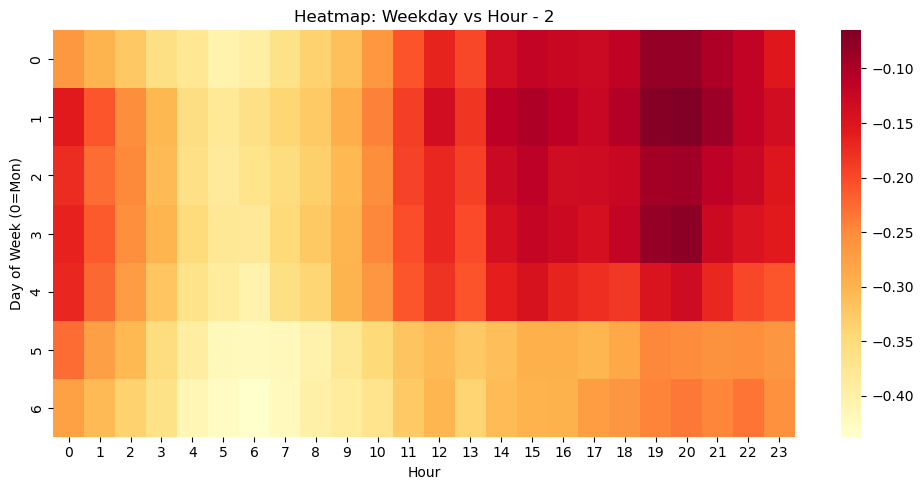

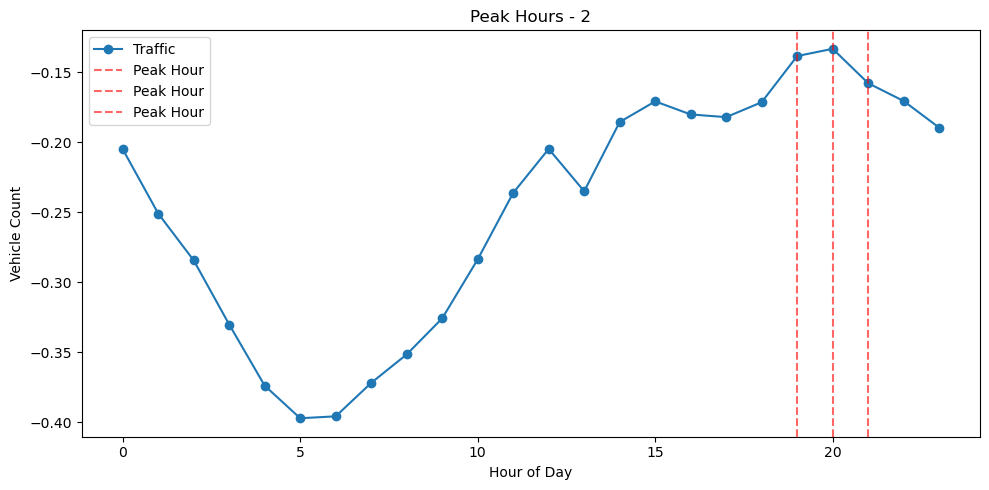

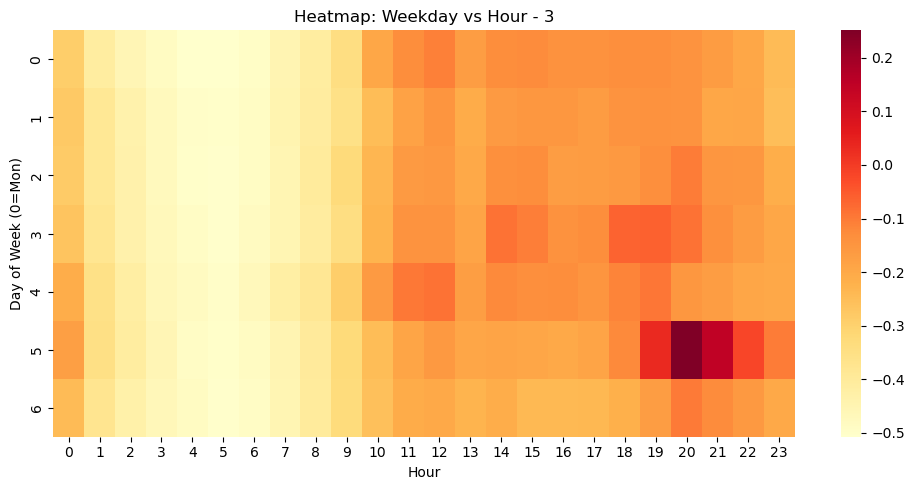

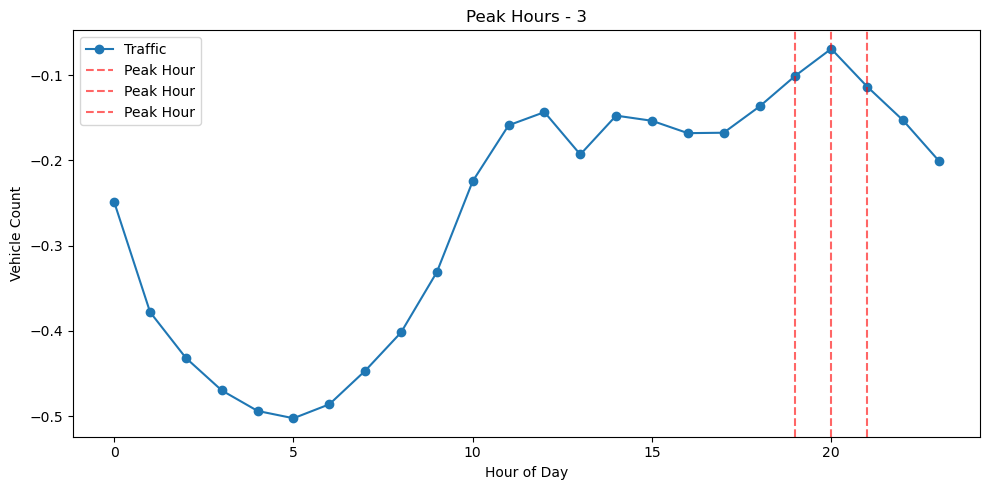

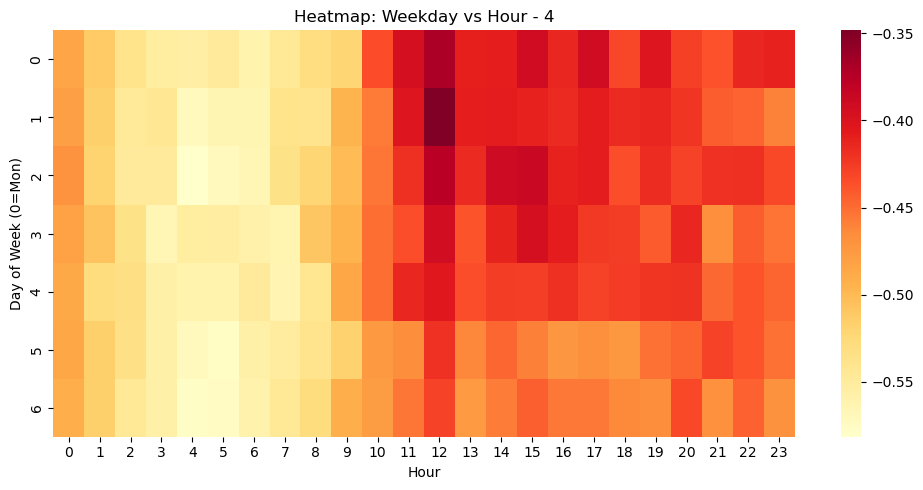

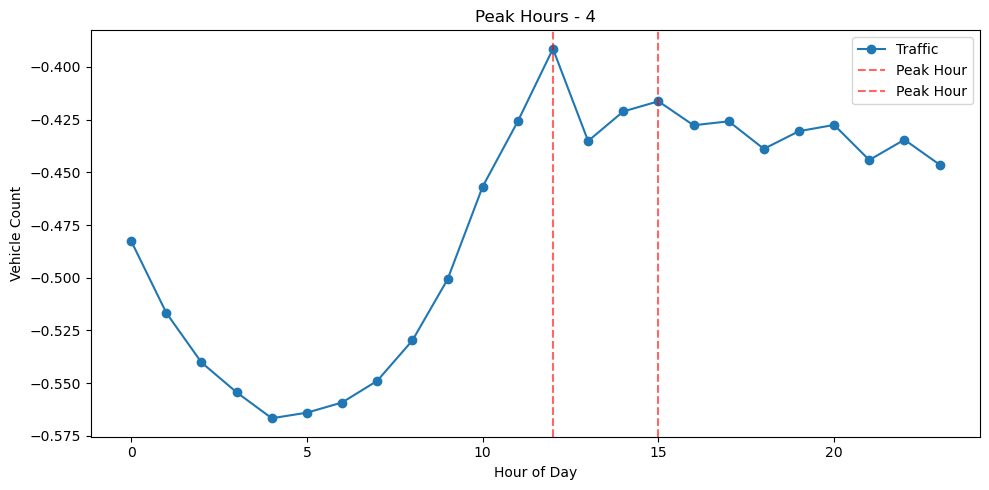

In [96]:
# Visualizations

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure index is datetime
df.index = pd.to_datetime(df.index)

# Loop through each junction and generate visualizations
for junc in df['junction_id'].unique():
    sub = df[df['junction_id'] == junc]

    # Heatmap: Weekday vs Hour
    pivot = sub.groupby([sub.index.weekday, sub.index.hour])['vehicle_count'].mean().unstack()
    plt.figure(figsize=(10,5))
    sns.heatmap(pivot, cmap='YlOrRd')
    plt.title(f"Heatmap: Weekday vs Hour - {junc}")
    plt.xlabel("Hour")
    plt.ylabel("Day of Week (0=Mon)")
    plt.tight_layout()
    plt.show()  # Show heatmap

    # Line plot with peak hours
    h = hourly[hourly['junction_id'] == junc]
    plt.figure(figsize=(10,5))
    plt.plot(h['hour'], h['vehicle_count'], marker='o', label='Traffic')
    
    match = peak_summary[peak_summary['junction'] == junc]
    if not match.empty:
        for p in match['peak_hours'].iloc[0]:
            plt.axvline(p, linestyle='--', alpha=0.6, color='r', label='Peak Hour')
    
    plt.title(f"Peak Hours - {junc}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Vehicle Count")
    plt.legend()
    plt.tight_layout()
    plt.show()  # Show line plot


In [97]:
# Quick helper functions
def get_peak_hours(junction_id):
    row = peak_summary[peak_summary['junction']==junction_id]
    return row['peak_hours'].iloc[0] if not row.empty else []

def plot_hourly(junction_id):
    h = hourly[hourly['junction_id']==junction_id]
    plt.plot(h['hour'], h['vehicle_count'], marker='o')
    for p in get_peak_hours(junction_id):
        plt.axvline(p, linestyle='--', alpha=0.6)
    plt.title(f"Hourly Profile - {junction_id}")
    plt.show()

print( "Try: get_peak_hours(1)  or  plot_hourly(1)")


Try: get_peak_hours(1)  or  plot_hourly(1)


[12, 19, 20]


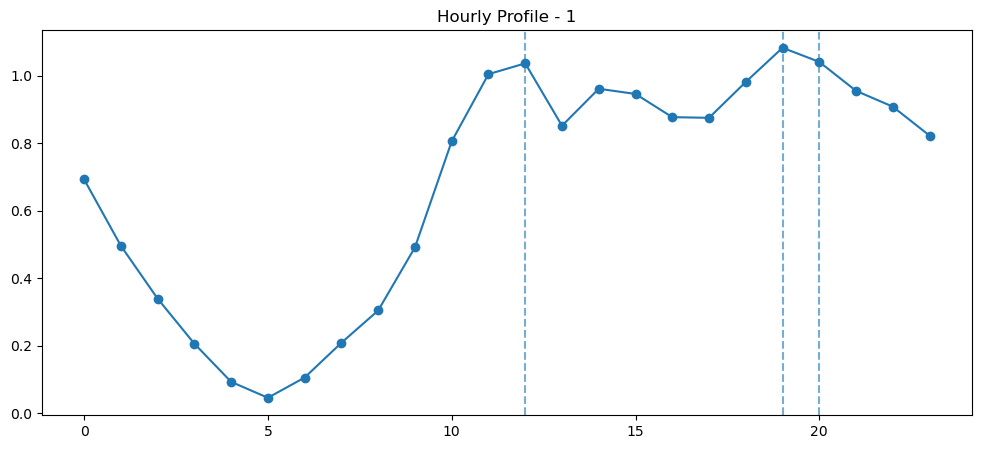

In [98]:
print(get_peak_hours(1))
plot_hourly(1)